# CITS5504 Data Warehousing Project 1

### Olympic Dataset: Data Warehouse Design and Multidimensional Analysis

### Jia Min Ho (23337561)


This notebook contains all the Python code and SQL queries for 
- Extract, transform, load (ETL) process
- Implementation of a multi-dimensional cube with Atoti
- Association rule mining
- What-if analysis

#### Business Queries for Client A (Australian Government):

1. How does Australia's GDP per capita correlate with its performance in the Summer Olympics across different years?

2. What is the distribution of Olympic medals won by Australia across different disciplines throughout the history of the Games, and which sport has yielded the highest number of medals?

3. Does Australia achieve better results in Olympic Games held domestically (home games) compared to those hosted internationally (away games)?

4. How does the changing life expectancy in Australia over the years influence the country's success rate in winning gold, silver, and bronze medals in swimming at the Summer Olympics?

5. Is there a correlation between population size in Australia and the total number of medals won at the Summer Olympics across the years?



#### Business Queries for Client B (French Government):
1. How does the GDP per capita of France correlate with its total medal count at the Summer Olympics over the years? 

2. How does the burden of depression, as measured by Disability-Adjusted Life Years (DALYs), correlate with France’s Fencing Summer Olympic performance from 1988 to 2020?

3. What is the distribution of Olympic medals won by France across various sports throughout the history of the Olympic Games, and which sport has delivered the highest number of medals?

4. How does the life expectancy in France correlate with the number of medals won in Alpine Skiing at the Olympics across the years?

5. Does France achieve improved outcomes in Olympic competitions hosted domestically as opposed to those held in international venues?


#### Extra Query for Clients A & B:
Identify the top 10 countries with the highest cumulative medal counts in Olympic history for a comprehensive overview of historical Olympic success.



#### Fact Tables:
- Primary Key: fact_id
- Foreign Keys: country_key, game_key, discipline_key, year_key
- Measures: medals_won, gold_medals, silver_medals, bronze_medals, GDP_per_capita, government_health_expenditure_per_capita, life_expectancy, DALY_depression, population_millions


#### Dimension Tables:
- **Country**: country_key (PK), country_name, region
- **Year**: year_key (PK), year
- **Game**: game_key (PK), game_name, game_season
- **Discipline**: discipline_key (PK), discipline_title, event_title

## Import Necessary Libraries

In [1217]:
import atoti as tt
import psycopg2
import pandas as pd
import numpy as np
import psycopg2

## Constructing JDBC URL for PostgreSQL Connection

In [1530]:
# Connect to the PostgreSQL database
db_name = "Olympic"
db_user = "postgres"
db_password = "postgres"  
db_host = "pgdb" 
db_port = "5432"

jdbc_url = f"jdbc:postgresql://{db_host}:{db_port}/{db_name}?user={db_user}&password={db_password}"

conn = psycopg2.connect(
    dbname=db_name, 
    user=db_user, 
    password=db_password, 
    host=db_host, 
    port=db_port
)

# Create a cursor object using the connection
cur = conn.cursor()

In [1531]:
from sqlalchemy import create_engine

# Create an SQLAlchemy engine
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

## Load Data From CSV Files

In [11]:
economic_data = pd.read_csv('olympic_data/Economic data.csv')
global_population = pd.read_csv('olympic_data/Global Population.csv', encoding='iso-8859-1')
life_expectancy = pd.read_csv('olympic_data/life-expectancy.csv')
countries_continent = pd.read_csv('olympic_data/list-of-countries_areas-by-continent-2024.csv')
mental_illness = pd.read_csv('olympic_data/mental-illness.csv')
olympic_hosts = pd.read_csv('olympic_data/olympic_hosts.csv')
olympic_medals = pd.read_csv('olympic_data/olympic_medals.csv')

## Create Tables and Insert Raw Data in PostgreSQL (Database: Olympic)

In [ ]:
# Insert data into the database from a pandas DataFrame
economic_data.to_sql('economic_data', engine, if_exists='append', index=False)
global_population.to_sql('global_population', engine, if_exists='append', index=False)
life_expectancy.to_sql('life_expectancy', engine, if_exists='append', index=False)
countries_continent.to_sql('countries_continent', engine, if_exists='append', index=False)
mental_illness.to_sql('mental_illness', engine, if_exists='append', index=False)
olympic_hosts.to_sql('olympic_hosts', engine, if_exists='append', index=False)
olympic_medals.to_sql('olympic_medals', engine, if_exists='append', index=False)

## ETL (Extract, Transform, Load)

## Extract PostgreSQL Tables into Pandas DataFrames

In [1532]:
# Extract PostgreSQL tables into pandas DataFrames
economic_data_table = pd.read_sql("SELECT * FROM economic_data", engine)
global_population_table = pd.read_sql("SELECT * FROM global_population", engine)
life_expectancy_table = pd.read_sql("SELECT * FROM life_expectancy", engine)
countries_continent_table = pd.read_sql("SELECT * FROM countries_continent", engine)
mental_illness_table = pd.read_sql("SELECT * FROM mental_illness", engine)
olympic_hosts_table = pd.read_sql("SELECT * FROM olympic_hosts", engine)
olympic_medals_table = pd.read_sql("SELECT * FROM olympic_medals", engine)

## Data Cleaning (Transformation)

### <font color='blue'>countries_continent</font> 


In [1533]:
countries_continent_clean = countries_continent_table

print('data shape:', countries_continent_clean.shape)
print('data types:\n', countries_continent_clean.dtypes)

data shape: (234, 2)
data types:
 country    object
region     object
dtype: object


In [1534]:
#!pip install pycountry

In [1535]:
import pycountry

# Define a dictionary for special cases or mismatches between country names and the pycountry database
special_cases = {
    "DR Congo": "COD",  
    "South Korea": "KOR", 
    "Ivory Coast": "CIV",  
    "Venezuela": "VEN",  
    "North Korea": "PRK",  
    "Syria": "SYR",  
    "Taiwan": "TWN", 
    "Bolivia": "BOL",  
    "Russia": "RUS",  
    "Vietnam": "VNM", 
    "Iran": "IRN",  
    "Tanzania": "TZA",  
    "Moldova": "MDA",  
    "Laos": "LAO",  
    "Czech Republic": "CZE",  
    "Republic of the Congo": "COG",  
    "Palestine": "PSE",  
    "Curacao": "CUW",  
    "Micronesia": "FSM",  
    "United States Virgin Islands": "VIR",  
    "British Virgin Islands": "VGB",  
    "Saint Martin": "MAF",  
    "Falkland Islands": "FLK",  
    "Vatican City": "VAT",  
    "Sint Maarten": "SXM", 
    "Brunei": "BRN", 
    "Turkey": "TUR",
    "Reunion": "REU",
    "Macau": "MAC",
    "Cape Verde": "CPV",
    "Saint Barthelemy": "BLM"
}

# Enhanced function to get country codes
def get_country_code_enhanced(country_name, code_format='alpha_3'):
    # Check special cases first
    if country_name in special_cases:
        return special_cases[country_name]
    try:
        # Attempt to get the country from pycountry
        return getattr(pycountry.countries.get(name=country_name), code_format)
    except AttributeError:
        # Try alternative lookup by common_name if the standard name fails
        try:
            return getattr(pycountry.countries.get(common_name=country_name), code_format)
        except AttributeError:
            # Final attempt by official_name
            try:
                return getattr(pycountry.countries.get(official_name=country_name), code_format)
            except AttributeError:
                return None

# Apply the enhanced function to DataFrame
countries_continent_clean['country_code'] = countries_continent_clean['country'].apply(lambda x: get_country_code_enhanced(x))

In [1536]:
missing_values = countries_continent_clean.isnull().sum()
print(missing_values)

country         0
region          0
country_code    0
dtype: int64


no missing values ✅

In [1537]:
# add a new row for "Historical/Special Cases" with "SPECIAL" as the country code
new_row = pd.DataFrame({'country': ['Historical/Special Cases'], 'region': ['SPECIAL'], 'country_code':['SPECIAL']})

# Using concat to add the new_row
countries_continent_clean = pd.concat([countries_continent_clean, new_row], ignore_index=True)

# Display the last few rows to confirm the addition
countries_continent_clean.tail()

,country,region,country_code
230,Falkland Islands,South America,FLK
231,Niue,Oceania,NIU
232,Tokelau,Oceania,TKL
233,Vatican City,Europe,VAT
234,Historical/Special Cases,SPECIAL,SPECIAL


### <font color='blue'>olympic_hosts</font> 


In [1538]:
olympic_hosts_clean = olympic_hosts_table
olympic_hosts_clean['game_start_date'] = pd.to_datetime(olympic_hosts_clean['game_start_date'])
olympic_hosts_clean['game_end_date'] = pd.to_datetime(olympic_hosts_clean['game_end_date'])

print('data shape:', olympic_hosts_clean.shape)
print('data types:\n', olympic_hosts_clean.dtypes)

data shape: (53, 7)
data types:
 game_slug                       object
game_end_date      datetime64[ns, UTC]
game_start_date    datetime64[ns, UTC]
game_location                   object
game_name                       object
game_season                     object
game_year                        int64
dtype: object


In [1539]:
missing_values = olympic_hosts_clean.isnull().sum()
print(missing_values)

game_slug          0
game_end_date      0
game_start_date    0
game_location      0
game_name          0
game_season        0
game_year          0
dtype: int64


no missing values! ✅

In [1540]:
# Extract unique country names from both datasets for comparison
olympic_countries = olympic_hosts_clean['game_location'].unique()
countries_countries = countries_continent_clean['country'].unique()

# Display the unique names from both datasets for manual inspection and comparison
{
    "olympic_countries": olympic_countries,
    "countries_countries": countries_countries
}

{'olympic_countries': array(['China', 'Japan', 'Republic of Korea', 'Brazil',
        'Russian Federation', 'Great Britain', 'Canada', 'Italy', 'Greece',
        'United States', 'Australia', 'Norway', 'Spain', 'France',
        'Yugoslavia', 'USSR', 'Austria', 'Federal Republic of Germany',
        'Mexico', 'Australia, Sweden', 'Finland', 'Switzerland', 'Germany',
        'Netherlands', 'Belgium', 'Sweden'], dtype=object),
 'countries_countries': array(['India', 'China', 'United States', 'Indonesia', 'Pakistan',
        'Nigeria', 'Brazil', 'Bangladesh', 'Russia', 'Ethiopia', 'Mexico',
        'Japan', 'Philippines', 'Egypt', 'DR Congo', 'Vietnam', 'Iran',
        'Turkey', 'Germany', 'Thailand', 'Tanzania', 'United Kingdom',
        'France', 'South Africa', 'Italy', 'Kenya', 'Myanmar', 'Colombia',
        'South Korea', 'Uganda', 'Sudan', 'Spain', 'Iraq', 'Algeria',
        'Argentina', 'Afghanistan', 'Poland', 'Canada', 'Morocco',
        'Ukraine', 'Angola', 'Saudi Arabia', 'Uzbe

In [1541]:
# Mapping for changing the game_location names to align with the countries_areas_continent_2024 dataset
location_mapping = {
    "Republic of Korea": "South Korea",
    "Russian Federation": "Russia",
    "Great Britain": "United Kingdom",
    "USSR": "Russia", 
    "Federal Republic of Germany": "Germany",
    "Australia, Sweden": "Australia",
    "Yugoslavia": "Serbia"  
}

# Apply the mapping to the game_location column
olympic_hosts_clean['game_location'] = olympic_hosts_clean['game_location'].replace(location_mapping)

In [1542]:
# Convert the 'year' column to string
olympic_hosts_clean['game_year'] = olympic_hosts_clean['game_year'].astype(str)

In [1543]:
olympic_hosts_clean.head()

,game_slug,game_end_date,game_start_date,game_location,game_name,game_season,game_year
0,beijing-2022,2022-02-20 12:00:00+00:00,2022-02-04 15:00:00+00:00,China,Beijing 2022,Winter,2022
1,tokyo-2020,2021-08-08 14:00:00+00:00,2021-07-23 11:00:00+00:00,Japan,Tokyo 2020,Summer,2020
2,pyeongchang-2018,2018-02-25 08:00:00+00:00,2018-02-08 23:00:00+00:00,South Korea,PyeongChang 2018,Winter,2018
3,rio-2016,2016-08-21 21:00:00+00:00,2016-08-05 12:00:00+00:00,Brazil,Rio 2016,Summer,2016
4,sochi-2014,2014-02-23 16:00:00+00:00,2014-02-07 04:00:00+00:00,Russia,Sochi 2014,Winter,2014


### <font color='blue'>life_expectancy</font> 


In [1544]:
# rename life expectancy column
life_expectancy_clean = life_expectancy_table
life_expectancy_clean.rename(columns={'Period life expectancy at birth - Sex: all - Age: 0': 'life_expectancy'}, inplace=True)
life_expectancy_clean.rename(columns={'Entity': 'country'}, inplace=True)
life_expectancy_clean.rename(columns={'Year': 'year'}, inplace=True)

print('data shape:', life_expectancy_clean.shape)
print('data types:\n', life_expectancy_clean.dtypes)
life_expectancy_clean.head()

data shape: (20755, 4)
data types:
 country             object
Code                object
year                 int64
life_expectancy    float64
dtype: object


,country,Code,year,life_expectancy
0,Afghanistan,AFG,1950,27.7275
1,Afghanistan,AFG,1951,27.9634
2,Afghanistan,AFG,1952,28.4456
3,Afghanistan,AFG,1953,28.9304
4,Afghanistan,AFG,1954,29.2258


In [1545]:
missing_values = life_expectancy_clean.isnull().sum()
print(missing_values)

country               0
Code               1694
year                  0
life_expectancy       0
dtype: int64


In [1546]:
# Remove the 'Code' column
life_expectancy_clean = life_expectancy_clean.drop('Code', axis=1)

In [1547]:
# Mapping of alternate names to standardized names
alternate_name_mapping = {
    "Czechia": "Czech Republic",
    "Congo": "Republic of the Congo", 
    "Democratic Republic of Congo": "DR Congo",
    "Cote d'Ivoire": "Ivory Coast",
    "East Timor": "Timor-Leste",
    "Macao": "Macau",
    "Micronesia (country)": "Micronesia",
}

# List of non-country entities to remove
non_country_entities = [
    'Africa', 'Americas', 'Asia', 'Europe', 'Oceania', 
    'High-income countries', 'Low-income countries', 'Middle-income countries',
    'Land-locked Developing Countries (LLDC)', 'Least developed countries',
    'Less developed regions', 'Less developed regions, excluding China',
    'Less developed regions, excluding least developed countries', 
    'Latin America and the Caribbean', 'More developed regions',
    'No income group available', 'Northern America', 'World', 
    'Upper-middle-income countries', 'Lower-middle-income countries',
    'Bonaire Sint Eustatius and Saba', 'Saint Helena', 
    'Saint Martin (French part)', 'Sint Maarten (Dutch part)', 
    'Small Island Developing States (SIDS)', 'USSR', 
    'England and Wales', 'Northern Ireland', 'Scotland',
]


Next, apply the mappings to standardize country names and then filter out the non-country entities.

In [1548]:
# Apply the mapping to standardize country names
life_expectancy_clean['country'] = life_expectancy_clean['country'].replace(alternate_name_mapping)

# Remove non-country entities
life_expectancy_clean = life_expectancy_clean[~life_expectancy_clean['country'].isin(non_country_entities)]

In [1549]:
# Create a mapping dictionary from country names to country codes
country_code_mapping = countries_continent_clean.set_index('country')['country_code'].to_dict()

# Map the country codes to the life expectancy data based on the 'country' column
life_expectancy_clean['country_code'] = life_expectancy_clean['country'].map(country_code_mapping)

# Replace NaN values in 'country_code' column with 'SPECIAL'
life_expectancy_clean['country_code'] = life_expectancy_clean['country_code'].fillna('SPECIAL')

In [1550]:
# Convert the 'year' column to string
life_expectancy_clean['year'] =life_expectancy_clean['year'].astype(str)

life_expectancy_clean.head()

,country,year,life_expectancy,country_code
0,Afghanistan,1950,27.7275,AFG
1,Afghanistan,1951,27.9634,AFG
2,Afghanistan,1952,28.4456,AFG
3,Afghanistan,1953,28.9304,AFG
4,Afghanistan,1954,29.2258,AFG


### <font color='blue'>global_population</font> 


In [1551]:
# Remove first and last 2 rows (NaN)
global_population_clean = global_population_table.iloc[1:-2, :]

# Change "no data" to NaN
global_population_clean = global_population_clean.replace("no data", np.nan)

# Remove rows where all elements are NaN
global_population_clean = global_population_clean.dropna(how='all')

In [1552]:
# Identifying country names in the global population data that do not match the countries dataset
global_population_countries = global_population_clean['Population (Millions of people)'].unique()
countries_not_in_population = countries_continent_clean[~countries_continent_clean['country'].isin(global_population_countries)]['country'].unique()
population_countries_not_in_countries = global_population_clean[
    ~global_population_clean['Population (Millions of people)'].isin(countries_continent_clean['country'])
]['Population (Millions of people)'].unique()

{
    "countries_not_in_population": countries_not_in_population,
    "population_countries_not_in_countries": population_countries_not_in_countries
}

{'countries_not_in_population': array(['China', 'Russia', 'DR Congo', 'Turkey', 'South Korea',
        'Ivory Coast', 'North Korea', 'Taiwan', 'South Sudan', 'Cuba',
        'Laos', 'Hong Kong', 'Kyrgyzstan', 'Republic of the Congo',
        'Slovakia', 'Palestine', 'Gambia', 'North Macedonia', 'Reunion',
        'Macau', 'Cape Verde', 'Western Sahara', 'Brunei', 'Bahamas',
        'Guadeloupe', 'Martinique', 'Mayotte', 'French Guiana',
        'French Polynesia', 'New Caledonia', 'Sao Tome and Principe',
        'Curacao', 'Guam', 'Micronesia', 'Jersey',
        'United States Virgin Islands', 'Isle of Man', 'Cayman Islands',
        'Bermuda', 'Guernsey', 'Greenland', 'Faroe Islands',
        'Northern Mariana Islands', 'Turks and Caicos Islands',
        'Sint Maarten', 'American Samoa', 'Liechtenstein', 'Monaco',
        'Gibraltar', 'Saint Martin', 'British Virgin Islands',
        'Cook Islands', 'Anguilla', 'Wallis and Futuna',
        'Saint Barthelemy', 'Saint Pierre and Mique

In [1553]:
# Mapping for country name corrections
name_correction_mapping = {
    "Bahamas, The": "Bahamas",
    "Brunei Darussalam": "Brunei",
    "Cabo Verde": "Cape Verde",
    "China, People's Republic of": "China",
    "Congo, Dem. Rep. of the": "DR Congo",
    "Congo, Republic of ": "Republic of the Congo",
    "Côte d'Ivoire": "Ivory Coast",
    "Gambia, The": "Gambia",
    "Hong Kong SAR": "Hong Kong",
    "Korea, Republic of": "South Korea",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao P.D.R.": "Laos",
    "Macao SAR": "Macau",
    "Micronesia, Fed. States of": "Micronesia",
    "North Macedonia ": "North Macedonia",
    "Russian Federation": "Russia",
    "Slovak Republic": "Slovakia",
    "South Sudan, Republic of": "South Sudan",
    "São Tomé and Príncipe": "Sao Tome and Principe",
    "Taiwan Province of China": "Taiwan",
    "Türkiye, Republic of": "Turkey",
    "West Bank and Gaza": "Palestine",
}

# Apply the name corrections
global_population_clean['Population (Millions of people)'] = global_population_clean['Population (Millions of people)'].replace(name_correction_mapping)

# List of non-country entities to be removed. 
non_country_entities = [
    'Africa (Region)', 'Asia and Pacific', 'Australia and New Zealand', 'Caribbean',
    'Central America', 'Central Asia and the Caucasus', 'East Asia', 'Eastern Europe',
    'Europe', 'Middle East (Region)', 'North Africa', 'North America', 'Pacific Islands',
    'South America', 'South Asia', 'Southeast Asia', 'Sub-Saharan Africa (Region)',
    'Western Europe', 'Western Hemisphere (Region)', 'ASEAN-5', 'Advanced economies',
    'Emerging and Developing Asia', 'Emerging and Developing Europe',
    'Emerging market and developing economies', 'Euro area', 'European Union',
    'Latin America and the Caribbean', 'Major advanced economies (G7)',
    'Middle East and Central Asia', 'Other advanced economies', 'Sub-Saharan Africa', 'World',
]

# Remove non-country entities
global_population_clean = global_population_clean[~global_population_clean['Population (Millions of people)'].isin(non_country_entities)]

# Display a sample to confirm the changes
global_population_clean.sample(5)


,Population (Millions of people),1980,1981,1982,1983,1984,1985,1986,1987,1988,...,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028
118,Morocco,19.432,19.938,20.459,20.944,21.441,21.951,22.469,23.002,23.528,...,35.587,35.952,36.313,36.669,37.022,37.37,37.712,38.05,38.381,38.706
71,Guinea-Bissau,0.782,0.798,0.815,0.832,0.85,0.867,0.886,0.903,0.921,...,1.776,1.815,1.855,1.896,1.937,1.978,2.019,2.06,2.103,2.145
130,Norway,4.092,4.107,4.123,4.134,4.146,4.159,4.174,4.198,4.221,...,5.357,5.385,5.415,5.475,5.508,5.541,5.574,5.608,5.641,5.675
49,Dominica,NaN,0.074,0.074,0.073,0.073,0.073,0.072,0.072,0.072,...,0.072,0.073,0.074,0.074,0.074,0.075,0.075,0.076,0.076,0.076
6,Antigua and Barbuda,0.068,0.068,0.067,0.066,0.065,0.064,0.063,0.062,0.061,...,0.096,0.098,0.099,0.101,0.102,0.104,0.105,0.106,0.108,0.109


In [1554]:
# Transform global_population_clean to Long Format
global_population_clean = pd.melt(global_population_clean, id_vars=['Population (Millions of people)'], value_vars=[str(year) for year in range(1980, 2029)],
                                 var_name='year', value_name='population(millions)')

# Rename columns
global_population_clean.rename(columns={'Population (Millions of people)': 'country'}, inplace=True)

print('data shape:', global_population_clean.shape)
print('data types:\n', global_population_clean.dtypes)

data shape: (9751, 3)
data types:
 country                 object
year                    object
population(millions)    object
dtype: object


In [1555]:
missing_values = global_population_clean.isnull().sum()
print(missing_values)

country                   0
year                      0
population(millions)    821
dtype: int64


**Perform linear interpolation to estimate the missing population values by connecting the dots between available data points with straight lines.**

In [1556]:
# Ensure 'year' is of type int for sorting and interpolation purposes
global_population_clean['year'] = global_population_clean['year'].astype(int)

# Filter out rows with 'year' greater than 2024
global_population_clean = global_population_clean[global_population_clean['year'] <= 2024]

# Convert 'population(millions)' to a numeric type, errors='coerce' will convert non-convertible values to NaN, which can be useful if there are any non-numeric entries
global_population_clean['population(millions)'] = pd.to_numeric(global_population_clean['population(millions)'], errors='coerce')

# Sort the data by country and year to ensure interpolation works correctly
global_population_clean.sort_values(by=['country', 'year'], inplace=True)

# Perform linear interpolation on the 'population(millions)' column, grouped by country
global_population_clean['population(millions)'] = global_population_clean.groupby('country')['population(millions)'].transform(lambda x: x.interpolate())

# Convert 'year' back to string 
global_population_clean['year'] = global_population_clean['year'].astype(str)

# Check if there are still missing values after interpolation
missing_after_interpolation = global_population_clean['population(millions)'].isnull().sum()

print(f"Missing values after interpolation: {missing_after_interpolation}")


Missing values after interpolation: 772


**Forward Fill and Backward Fill to fill missing values by propagating the last known value forward or the next known value backward, respectively.**

In [1557]:
# Forward fill
global_population_clean['population(millions)'] = global_population_clean.groupby('country')['population(millions)'].ffill()

# Backward fill
global_population_clean['population(millions)'] = global_population_clean.groupby('country')['population(millions)'].bfill()

# Check if there are still missing values 
missing_after_fill = global_population_clean['population(millions)'].isnull().sum()

print(f"Missing values after fill: {missing_after_fill}")

Missing values after fill: 0


In [1558]:
# Map the country codes to the data based on the 'country' column
global_population_clean['country_code'] = global_population_clean['country'].map(country_code_mapping)

# Replace NaN values in 'country_code' column with 'SPECIAL'
global_population_clean['country_code'] = global_population_clean['country_code'].fillna('SPECIAL')

global_population_clean.tail(5)

,country,year,population(millions),country_code
8155,Zimbabwe,2020,15.189,ZWE
8354,Zimbabwe,2021,15.492,ZWE
8553,Zimbabwe,2022,15.817,ZWE
8752,Zimbabwe,2023,16.164,ZWE
8951,Zimbabwe,2024,16.481,ZWE


### <font color='blue'>mental_illness</font> 


In [1559]:
mental_illness_clean = mental_illness_table

mental_illness_clean.rename(columns={'Entity': 'country'}, inplace=True)

print('data shape:', mental_illness_clean.shape)
print('data types:\n', mental_illness_clean.dtypes)
mental_illness_clean.head()

data shape: (6840, 8)
data types:
 country                                                             object
Code                                                                object
Year                                                                 int64
DALYs from depressive disorders per 100,000 people in, both sex    float64
DALYs from schizophrenia per 100,000 people in, both sexes aged    float64
DALYs from bipolar disorder per 100,000 people in, both sexes a    float64
DALYs from eating disorders per 100,000 people in, both sexes a    float64
DALYs from anxiety disorders per 100,000 people in, both sexes     float64
dtype: object


,country,Code,Year,"DALYs from depressive disorders per 100,000 people in, both sex","DALYs from schizophrenia per 100,000 people in, both sexes aged","DALYs from bipolar disorder per 100,000 people in, both sexes a","DALYs from eating disorders per 100,000 people in, both sexes a","DALYs from anxiety disorders per 100,000 people in, both sexes"
0,Afghanistan,AFG,1990,895.22565,138.24825,147.64412,26.471115,440.33000
1,Afghanistan,AFG,1991,893.88434,137.76122,147.56696,25.548681,439.47202
2,Afghanistan,AFG,1992,892.34973,137.08030,147.13086,24.637949,437.60718
3,Afghanistan,AFG,1993,891.51587,136.48602,146.78812,23.863169,436.69104
4,Afghanistan,AFG,1994,891.39160,136.18323,146.58481,23.189074,436.76800


In [1560]:
missing_values = mental_illness_clean.isnull().sum()
print(missing_values)

country                                                              0
Code                                                               690
Year                                                                 0
DALYs from depressive disorders per 100,000 people in, both sex      0
DALYs from schizophrenia per 100,000 people in, both sexes aged      0
DALYs from bipolar disorder per 100,000 people in, both sexes a      0
DALYs from eating disorders per 100,000 people in, both sexes a      0
DALYs from anxiety disorders per 100,000 people in, both sexes       0
dtype: int64


In [1561]:
# Identifying entities in the mental illness data that do not match country names in the countries dataset
entities_not_in_countries = mental_illness_clean[~mental_illness_clean['country'].isin(countries_continent_clean['country'])]['country'].unique()
countries_not_in_entities = countries_continent_clean[~countries_continent_clean['country'].isin(mental_illness_clean['country'])]['country'].unique()

{
    "entities_not_in_countries": entities_not_in_countries,
    "countries_not_in_entities": countries_not_in_entities
}


{'entities_not_in_countries': array(['African Region (WHO)', 'Congo', "Cote d'Ivoire", 'Czechia',
        'Democratic Republic of Congo', 'East Asia & Pacific (WB)',
        'East Timor', 'Eastern Mediterranean Region (WHO)', 'England',
        'Europe & Central Asia (WB)', 'European Region (WHO)', 'G20',
        'High Income (WB)', 'Latin America & Caribbean (WB)',
        'Low Income (WB)', 'Lower Middle Income (WB)',
        'Micronesia (country)', 'Middle East & North Africa (WB)',
        'Middle Income (WB)', 'North America (WB)', 'Northern Ireland',
        'OECD Countries', 'Region of the Americas (WHO)', 'Scotland',
        'South Asia (WB)', 'South-East Asia Region (WHO)',
        'Sub-Saharan Africa (WB)', 'Wales', 'Western Pacific Region (WHO)',
        'World'], dtype=object),
 'countries_not_in_entities': array(['DR Congo', 'Ivory Coast', 'Czech Republic', 'Hong Kong',
        'Republic of the Congo', 'Timor-Leste', 'Reunion', 'Macau',
        'Western Sahara', 'Guadeloup

In [1562]:
# Mapping for name corrections including specific countries and general entities to be removed or corrected
name_correction_mapping = {
    "Congo": "Republic of the Congo",
    "Cote d'Ivoire": "Ivory Coast",
    "Czechia": "Czech Republic",
    "Democratic Republic of Congo": "DR Congo",
    "East Timor": "Timor-Leste",
    "Micronesia (country)": "Micronesia",
}

# Apply the name corrections
mental_illness_clean['country'] = mental_illness_clean['country'].replace(name_correction_mapping)

# Identifying non-country entities from the provided list to be removed
non_country_entities = [
    'African Region (WHO)', 'East Asia & Pacific (WB)', 'Eastern Mediterranean Region (WHO)',
    'Europe & Central Asia (WB)', 'European Region (WHO)', 'G20', 'High Income (WB)',
    'Latin America & Caribbean (WB)', 'Low Income (WB)', 'Lower Middle Income (WB)',
    'Middle East & North Africa (WB)', 'Middle Income (WB)', 'North America (WB)',
    'Region of the Americas (WHO)', 'South Asia (WB)', 'South-East Asia Region (WHO)',
    'Sub-Saharan Africa (WB)', 'Western Pacific Region (WHO)', 'World',
    # Including specific UK countries due to them being part of the UK
    'England', 'Northern Ireland', 'Scotland', 'Wales',
    'OECD Countries', # This and other regional or income-based classifications
]

# Remove non-country entities
mental_illness_clean = mental_illness_clean[~mental_illness_clean['country'].isin(non_country_entities)]

In [1563]:
# Keeping only the specified columns and renaming 
mental_illness_clean = mental_illness_clean[['country', 'Year', 'DALYs from depressive disorders per 100,000 people in, both sex']].copy()
mental_illness_clean.rename(columns={
    'Year': 'year',
    'DALYs from depressive disorders per 100,000 people in, both sex': 'DALY_depression'
}, inplace=True)

# Map the country codes to the data based on the 'country' column
mental_illness_clean['country_code'] = mental_illness_clean['country'].map(country_code_mapping)

# Replace NaN values in 'country_code' column with 'SPECIAL'
mental_illness_clean['country_code'] = mental_illness_clean['country_code'].fillna('SPECIAL')

In [1564]:
# Convert the 'year' column to string
mental_illness_clean['year'] =mental_illness_clean['year'].astype(str)

mental_illness_clean.head()

,country,year,DALY_depression,country_code
0,Afghanistan,1990,895.22565,AFG
1,Afghanistan,1991,893.88434,AFG
2,Afghanistan,1992,892.34973,AFG
3,Afghanistan,1993,891.51587,AFG
4,Afghanistan,1994,891.39160,AFG


### <font color='blue'>economic_data</font> 


As the economic data given only includes year 2020 data, external data was downloaded from https://databank.worldbank.org/source/world-development-indicators to include year 1960 to 2022

In [1565]:
# externally downloaded economic data (year 1960-2022)
economic_data_1960_2022 = pd.read_csv('olympic_data/economic_data_1960_2022.csv')

In [1566]:
# remove last 5 rows (irrelevant)
economic_data_clean = economic_data_1960_2022.iloc[0:-5, :].copy()

# convert .. to NaN
economic_data_clean.replace('..', np.nan, inplace=True)

print('data shape:', economic_data_clean.shape)
print('data types:\n', economic_data_clean.dtypes)

data shape: (13671, 13)
data types:
 Time                                                                                           object
Time Code                                                                                      object
Country Name                                                                                   object
Country Code                                                                                   object
Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population) [SI.POV.DDAY]              object
GDP per capita (current US$) [NY.GDP.PCAP.CD]                                                  object
GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG]                                           object
Secure Internet servers (per 1 million people) [IT.NET.SECR.P6]                                object
Mortality rate, infant (per 1,000 live births) [SP.DYN.IMRT.IN]                                object
Current health expenditure (% of GDP) [SH.XPD

In [1567]:
missing_values = economic_data_clean.isnull().sum()
print(missing_values)

Time                                                                                               0
Time Code                                                                                          0
Country Name                                                                                       0
Country Code                                                                                       0
Poverty headcount ratio at $2.15 a day (2017 PPP) (% of population) [SI.POV.DDAY]              11560
GDP per capita (current US$) [NY.GDP.PCAP.CD]                                                   3198
GDP per capita growth (annual %) [NY.GDP.PCAP.KD.ZG]                                            3578
Secure Internet servers (per 1 million people) [IT.NET.SECR.P6]                                11338
Mortality rate, infant (per 1,000 live births) [SP.DYN.IMRT.IN]                                 2611
Current health expenditure (% of GDP) [SH.XPD.CHEX.GD.ZS]                                  

In [1568]:
# Remove 'Country Code' and 'Time Code' columns
economic_data_clean = economic_data_clean.drop(['Country Code', 'Time Code'], axis=1)

# Applying similar name corrections as before
name_correction_mapping = {
    "Congo, Dem. Rep.": "DR Congo",
    "Congo, Rep.": "Republic of the Congo",
    "Cote d'Ivoire": "Ivory Coast",
    "Egypt, Arab Rep.": "Egypt",
    "Gambia, The": "Gambia",
    "Iran, Islamic Rep.": "Iran",
    "Korea, Rep.": "South Korea",
    "Kyrgyz Republic": "Kyrgyzstan",
    "Lao PDR": "Laos",
    "Micronesia, Fed. Sts.": "Micronesia",
    "Russian Federation": "Russia",
    "Slovak Republic": "Slovakia",
    "Venezuela, RB": "Venezuela",
    "Yemen, Rep.": "Yemen",
    "Bahamas, The": "Bahamas",
    "Brunei Darussalam": "Brunei",
    "Cabo Verde": "Cape Verde",
    "Czechia": "Czech Republic",
    "St. Kitts and Nevis": "Saint Kitts and Nevis",
    "St. Lucia": "Saint Lucia",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "Syrian Arab Republic": "Syria",
    "Turkiye": "Turkey",
    "Viet Nam": "Vietnam",
}

# Apply the name corrections
economic_data_clean['Country Name'] = economic_data_clean['Country Name'].replace(name_correction_mapping)

# Identifying non-country entities to be removed
non_country_entities = [
    # Adding specific WHO and World Bank regions, G20, OECD Countries, income classifications, etc.
    'African Region (WHO)', 'East Asia & Pacific (WB)', 'Eastern Mediterranean Region (WHO)',
    'Europe & Central Asia (WB)', 'European Region (WHO)', 'G20', 'High Income (WB)',
    'Latin America & Caribbean (WB)', 'Low Income (WB)', 'Lower Middle Income (WB)',
    'Middle East & North Africa (WB)', 'Middle Income (WB)', 'North America (WB)',
    'Region of the Americas (WHO)', 'South Asia (WB)', 'South-East Asia Region (WHO)',
    'Sub-Saharan Africa (WB)', 'Western Pacific Region (WHO)', 'World'
]

# Remove non-country entities
economic_data_clean = economic_data_clean[~economic_data_clean['Country Name'].isin(non_country_entities)]

In [1569]:
# Keeping only the specified columns and renaming 
economic_data_clean = economic_data_clean[['Time', 'Country Name', 'GDP per capita (current US$) [NY.GDP.PCAP.CD]', 'Domestic general government health expenditure per capita (current US$) [SH.XPD.GHED.PC.CD]']].copy()
economic_data_clean.rename(columns={
    'Time': 'year',
    'Country Name': 'country',
    'GDP per capita (current US$) [NY.GDP.PCAP.CD]': 'GDP_per_capita',
    'Domestic general government health expenditure per capita (current US$) [SH.XPD.GHED.PC.CD]': 'government_health_expenditure_per_capita'
}, inplace=True)

# Map the country codes to the data based on the 'country' column
economic_data_clean['country_code'] = economic_data_clean['country'].map(country_code_mapping)

# Replace NaN values in 'country_code' column with 'SPECIAL'
economic_data_clean['country_code'] = economic_data_clean['country_code'].fillna('SPECIAL')

In [1570]:
# Impute missing values using forward fill followed by backward fill for time-series data
economic_data_clean = economic_data_clean.sort_values(by=['country', 'year'])
economic_data_clean = economic_data_clean.groupby('country').apply(lambda group: group.ffill().bfill())

# Drop remaining rows with NaN values if they still exist after imputation
economic_data_clean.dropna(subset=cols_to_convert, inplace=True)

/tmp/ipykernel_96/3381036207.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  economic_data_clean = economic_data_clean.groupby('country').apply(lambda group: group.ffill().bfill())


In [1571]:
# Drop the 'country' column if it's duplicate, then reset index
economic_data_clean = economic_data_clean.drop(columns=['country'], errors='ignore').reset_index()
economic_data_clean.drop(columns=['level_1'], inplace=True)

In [1572]:
# Convert the 'year' column to string
economic_data_clean['year'] =economic_data_clean['year'].astype(str)

In [1573]:
economic_data_clean.sample(5)

,country,year,GDP_per_capita,government_health_expenditure_per_capita,country_code
6163,Luxembourg,2012,112584.676270958,5042.71027031,LUX
10510,Tajikistan,2012,959.36021750698,15.42647015,TJK
4156,Grenada,2021,9010.5127999358,193.04138697,GRD
10198,Sudan,2015,2226.40942382813,38.00096672,SDN
1495,Brazil,2006,5866.02341427165,207.73388677,BRA


### <font color='blue'>olympic_medals</font> 


In [1574]:
olympic_medals_clean = olympic_medals_table

print('data shape:', olympic_medals_clean.shape)
print('data types:\n', olympic_medals_clean.dtypes)

data shape: (21697, 12)
data types:
 discipline_title         object
slug_game                object
event_title              object
event_gender             object
medal_type               object
participant_type         object
participant_title        object
athlete_url              object
athlete_full_name        object
country_name             object
country_code             object
country_3_letter_code    object
dtype: object


In [1575]:
missing_values = olympic_medals_clean.isnull().sum()
print(missing_values)

discipline_title             0
slug_game                    0
event_title                  0
event_gender                 0
medal_type                   0
participant_type             0
participant_title        15113
athlete_url               4670
athlete_full_name         3624
country_name                 0
country_code              1502
country_3_letter_code        0
dtype: int64


In [1576]:
# Identifying unique country names in both datasets
olympic_countries = set(olympic_medals_clean['country_name'].unique())
countries_areas_countries = set(countries_continent_clean['country'].unique())

# Finding countries in the olympic dataset not in the countries_areas_continent dataset
olympic_not_in_countries_areas = olympic_countries - countries_areas_countries

# Finding countries in the countries_areas_continent dataset not in the olympic dataset
countries_areas_not_in_olympic = countries_areas_countries - olympic_countries

olympic_not_in_countries_areas, countries_areas_not_in_olympic


({'Australasia',
  'Bohemia',
  'Chinese Taipei',
  'Czechoslovakia',
  "Côte d'Ivoire",
  "Democratic People's Republic of Korea",
  'Federal Republic of Germany',
  'German Democratic Republic (Germany)',
  'Great Britain',
  'Hong Kong, China',
  'Independent Olympic Athletes',
  'Islamic Republic of Iran',
  'Kosovo',
  'MIX',
  'Netherlands Antilles',
  'Olympic Athletes from Russia',
  "People's Republic of China",
  'ROC',
  'Republic of Korea',
  'Republic of Moldova',
  'Russian Federation',
  'Serbia and Montenegro',
  'Soviet Union',
  'Syrian Arab Republic',
  'Unified Team',
  'United Arab Republic',
  'United Republic of Tanzania',
  'United States of America',
  'Virgin Islands, US',
  'West Indies Federation',
  'Yugoslavia'},
 {'Albania',
  'American Samoa',
  'Andorra',
  'Angola',
  'Anguilla',
  'Antigua and Barbuda',
  'Aruba',
  'Bangladesh',
  'Belize',
  'Benin',
  'Bhutan',
  'Bolivia',
  'Bosnia and Herzegovina',
  'British Virgin Islands',
  'Brunei',
  'Camb

In [1577]:
# Creating a mapping of country name corrections
country_name_corrections = {
    "Great Britain": "United Kingdom",
    "United States of America": "United States",
    "People's Republic of China": "China",
    "Republic of Korea": "South Korea",
    "Democratic People's Republic of Korea": "North Korea",
    "Russian Federation": "Russia",
    "Côte d'Ivoire": "Ivory Coast",
    "Islamic Republic of Iran": "Iran",
    "Republic of Moldova": "Moldova",
    "Hong Kong, China": "Hong Kong",
    "Syrian Arab Republic": "Syria",
    "Republic of Tanzania": "Tanzania",
    "Virgin Islands, US": "United States Virgin Islands",
    "Australasia": "Australasia",  # Historical, no change needed
    "Bohemia": "Bohemia",  # Historical, no change needed
    "Chinese Taipei": "Taiwan",
    "Czechoslovakia": "Czechoslovakia",  # Historical, no change needed
    "Democratic People's Republic of Korea": "North Korea",
    "Federal Republic of Germany": "Germany",  
    "German Democratic Republic (Germany)": "Germany",  
    "Independent Olympic Athletes": "Independent Olympic Athletes",  # Special, no change needed
    "Kosovo": "Kosovo",
    "MIX": "Mixed Team",
    "Netherlands Antilles": "Netherlands Antilles",  # No longer exists, keep for historical accuracy
    "Olympic Athletes from Russia": "Russia",  
    "ROC": "ROC",  # Special, no change needed
    "Serbia and Montenegro": "Serbia and Montenegro",  # Historical, no change needed
    "Soviet Union": "Soviet Union",  # Historical, no change needed
    "Unified Team": "Unified Team",  # Historical, no change needed
    "United Arab Republic": "United Arab Republic",  # Historical, no change needed
    "United Republic of Tanzania": "Tanzania",
    "West Indies Federation": "West Indies Federation",  # Historical, no change needed
    "Yugoslavia": "Yugoslavia"  # Historical, no change needed
}

# Applying the corrections
olympic_medals_clean['country_name'] = olympic_medals_clean['country_name'].apply(lambda x: country_name_corrections.get(x, x))

# Verifying the correction by checking if there are any country names in olympic_medals that are still not in countries_areas_continent
olympic_countries_corrected = set(olympic_medals_clean['country_name'].unique())
olympic_not_in_countries_areas_corrected = olympic_countries_corrected - countries_areas_countries

olympic_not_in_countries_areas_corrected


{'Australasia',
 'Bohemia',
 'Czechoslovakia',
 'Independent Olympic Athletes',
 'Kosovo',
 'Mixed Team',
 'Netherlands Antilles',
 'ROC',
 'Serbia and Montenegro',
 'Soviet Union',
 'Unified Team',
 'United Arab Republic',
 'West Indies Federation',
 'Yugoslavia'}

Historical entities and teams (e.g., "Australasia", "Bohemia", "Czechoslovakia", "Federal Republic of Germany", "German Democratic Republic (Germany)", "Serbia and Montenegro", "Soviet Union", "Unified Team", "United Arab Republic", "West Indies Federation", "Yugoslavia"): These refer to countries or teams that existed under these names during certain periods. For historical accuracy, these names should generally be retained as is, unless there's a specific reason to map them to their modern counterparts.

Special Olympic entities:

"Chinese Taipei" is commonly used in international sports contexts for Taiwan.
"Independent Olympic Athletes" refers to athletes who compete independently of any national team, often due to specific geopolitical reasons.
"Olympic Athletes from Russia" and "ROC" (Russian Olympic Committee) are designations used for Russian athletes competing under neutral flags due to sanctions against Russia. These could be labeled under a neutral or generic category if separating them from Russia is required.
"MIX" refers to mixed teams composed of athletes from different countries, often seen in team sports. This designation could be kept as is.
Country name variations and corrections:

"Côte d'Ivoire" is already corrected to "Ivory Coast".
"Democratic People's Republic of Korea" should be "North Korea".
"Great Britain" is corrected to "United Kingdom".
"Hong Kong, China" should be "Hong Kong".
"Islamic Republic of Iran" is "Iran".
"People's Republic of China" is "China".
"Republic of Korea" is "South Korea".
"Republic of Moldova" is "Moldova".
"Russian Federation" is "Russia".
"Syrian Arab Republic" is "Syria".
"United States of America" is "United States".
"Virgin Islands, US" should be "United States Virgin Islands".
"United Republic of Tanzania" is "Tanzania".
New or less commonly recognized entities:

"Kosovo" and "Netherlands Antilles": For "Kosovo", it is recognized by many countries and international organizations. The "Netherlands Antilles" dissolved in 2010 into separate entities, and athletes from this region now compete for the Netherlands or as part of other successor entities.

In [1578]:
# Keeping only the specified columns and renaming 
olympic_medals_clean = olympic_medals_clean[['discipline_title', 'slug_game', 'event_title', 'event_gender', 'medal_type', 'country_name']].copy()
olympic_medals_clean.rename(columns={
    'country_name': 'country',
    'slug_game': 'game_slug'
}, inplace=True)

# Map the country codes to the data based on the 'country' column
olympic_medals_clean['country_code'] = olympic_medals_clean['country'].map(country_code_mapping)

# Replace NaN values in 'country_code' column with 'SPECIAL'
olympic_medals_clean['country_code'] = olympic_medals_clean['country_code'].fillna('SPECIAL')

In [1579]:
# Merge olympic_medals_clean with a subset of olympic_hosts (just the columns needed for the merge plus game_year)
olympic_medals_clean = pd.merge(
    olympic_medals_clean,
    olympic_hosts_clean[['game_slug', 'game_year']],
    on='game_slug',
    how='left'  # Use 'left' to keep all rows in olympic_medals_clean even if there's no matching game_slug in dim_olympic
)

# Now, olympic_medals_clean contains all columns from olympic_medals_clean plus the game_year from dim_olympic

medals_won: A column added with the value 1 in every row, indicating that each row represents one medal won.

gold_medal: A column where the value is 1 if the medal type is 'GOLD', otherwise 0.

silver_medal: A column where the value is 1 if the medal type is 'SILVER', otherwise 0.

bronze_medal: A column where the value is 1 if the medal type is 'BRONZE', otherwise 0.

In [1580]:
# Add 'medals_won' column with value 1 in every row
olympic_medals_clean['medals_won'] = 1

# Add 'gold_medal', 'silver_medal', and 'bronze_medal' columns with 1 if the condition is met, else 0
olympic_medals_clean['gold_medal'] = (olympic_medals_clean['medal_type'] == 'GOLD').astype(int)
olympic_medals_clean['silver_medal'] = (olympic_medals_clean['medal_type'] == 'SILVER').astype(int)
olympic_medals_clean['bronze_medal'] = (olympic_medals_clean['medal_type'] == 'BRONZE').astype(int)

In [1581]:
# Convert the 'year' column to string
olympic_medals_clean['game_year'] =olympic_medals_clean['game_year'].astype(str)

In [1582]:
# Check the result
olympic_medals_clean.sample(5)

,discipline_title,game_slug,event_title,event_gender,medal_type,country,country_code,game_year,medals_won,gold_medal,silver_medal,bronze_medal
8592,Canoe Sprint,atlanta-1996,K1 500m kayak single women,Women,BRONZE,Italy,ITA,1996,1,0,0,1
1252,Athletics,tokyo-2020,Women's 200m,Women,BRONZE,United States,USA,2020,1,0,0,1
20344,Tennis,stockholm-1912,doubles indoor men,Men,BRONZE,United Kingdom,GBR,1912,1,0,0,1
10068,Sailing,barcelona-1992,board lechner women,Women,BRONZE,Netherlands,NLD,1992,1,0,0,1
11568,Fencing,los-angeles-1984,épée team men,Men,SILVER,France,FRA,1984,1,0,1,0


### <font color='red'> Merge Data </font> 

In [1583]:
# dropping 'country_code' from dataframes before merging
global_population_clean = global_population_clean.drop('country_code', axis=1)
life_expectancy_clean = life_expectancy_clean.drop('country_code', axis=1)
mental_illness_clean = mental_illness_clean.drop('country_code', axis=1)

# merge data
economic_population = pd.merge(economic_data_clean, global_population_clean, on=['country', 'year'], how='left')
economic_population_lifeexpectancy = pd.merge(economic_population, life_expectancy_clean, on=['country', 'year'], how='left')
economic_population_lifeexpectancy_mental = pd.merge(economic_population_lifeexpectancy, mental_illness_clean, on=['country', 'year'], how='left')

In [1584]:
# Reset index before applying the operation to maintain alignment
economic_population_lifeexpectancy_mental.reset_index(inplace=True, drop=True)

# Apply the forward and backward fill operation
economic_population_lifeexpectancy_mental['population(millions)'] = (
    economic_population_lifeexpectancy_mental.groupby('country')['population(millions)']
    .transform(lambda x: x.ffill().bfill())
)

economic_population_lifeexpectancy_mental['life_expectancy'] = (
    economic_population_lifeexpectancy_mental.groupby('country')['life_expectancy']
    .transform(lambda x: x.ffill().bfill())
)

economic_population_lifeexpectancy_mental['DALY_depression'] = (
    economic_population_lifeexpectancy_mental.groupby('country')['DALY_depression']
    .transform(lambda x: x.ffill().bfill())
)

In [1585]:
missing_values = economic_population_lifeexpectancy_mental.isnull().sum()
print(missing_values)

country                                       0
year                                          0
GDP_per_capita                                0
government_health_expenditure_per_capita      0
country_code                                  0
population(millions)                        126
life_expectancy                               0
DALY_depression                               0
dtype: int64


In [1586]:
# Filter to find rows with missing 'population(millions)'
missing_population_rows = economic_population_lifeexpectancy_mental[
    economic_population_lifeexpectancy_mental['population(millions)'].isnull()
]

# Extract unique countries from the rows with missing 'population(millions)', assuming the correct column name is verified
unique_countries_missing_population = missing_population_rows['country'].unique()

# Print the unique countries to investigate further
unique_countries_missing_population


array(['Cuba', 'Monaco'], dtype=object)

Cuba and Monaco doesn't have population information. Since our analysis doesn't involve these 2 countries but still want to keep overall olympic performance across the world, let's still keep these 2 countries information and insert 9999 to these 2 countries' population.

In [1587]:
# First, identify the rows where the country is either 'Cuba' or 'Monaco' and the 'population(millions)' column is NaN
# Then, assign the value 9999 to these specific conditions

# Ensure the DataFrame is indexed properly
economic_population_lifeexpectancy_mental.reset_index(drop=True, inplace=True)

# Assign 9999 to population(millions) for Cuba and Monaco where it is currently NaN
economic_population_lifeexpectancy_mental.loc[
    (economic_population_lifeexpectancy_mental['country'].isin(['Cuba', 'Monaco'])) & 
    (economic_population_lifeexpectancy_mental['population(millions)'].isnull()), 
    'population(millions)'
] = 9999

# Check the modifications by filtering rows for Cuba and Monaco to ensure the update is correct
# economic_population_lifeexpectancy_mental.loc[
#     economic_population_lifeexpectancy_mental['country'].isin(['Cuba', 'Monaco'])
# ]


In [1588]:
# merge olympic_medals with olympic_hosts
medals_hosts = pd.merge(olympic_medals_clean, olympic_hosts_clean, on=['game_year'], how='left')

In [1589]:
missing_values = medals_hosts.isnull().sum()
print(missing_values)

discipline_title    0
game_slug_x         0
event_title         0
event_gender        0
medal_type          0
country             0
country_code        0
game_year           0
medals_won          0
gold_medal          0
silver_medal        0
bronze_medal        0
game_slug_y         0
game_end_date       0
game_start_date     0
game_location       0
game_name           0
game_season         0
dtype: int64


In [1590]:
# Standardizing country names in both datasets
medals_hosts['country'] = medals_hosts['country'].str.capitalize()
economic_population_lifeexpectancy_mental['country'] = economic_population_lifeexpectancy_mental['country'].str.capitalize()

# Convert 'game_year' and 'year' to the same data type
medals_hosts['game_year'] = medals_hosts['game_year'].astype(str)
economic_population_lifeexpectancy_mental['year'] = economic_population_lifeexpectancy_mental['year'].astype(str)


In [1591]:
medals_hosts.rename(columns={'game_year': 'year'}, inplace=True)

In [1592]:
# Checking the unique country codes in both datasets
unique_medal_country_codes = set(medals_hosts['country_code'].unique())
unique_economic_country_codes = set(economic_population_lifeexpectancy_mental['country_code'].unique())

# Checking for mismatches in country codes between the two datasets
codes_in_medal_not_in_economic = unique_medal_country_codes - unique_economic_country_codes
codes_in_economic_not_in_medal = unique_economic_country_codes - unique_medal_country_codes

codes_in_medal_not_in_economic, codes_in_economic_not_in_medal

({'BMU', 'HKG', 'LIE', 'PRI', 'PRK', 'SPECIAL', 'TWN', 'VIR'},
 {'AGO',
  'ALB',
  'AND',
  'ATG',
  'BEN',
  'BGD',
  'BIH',
  'BLZ',
  'BOL',
  'BRN',
  'BTN',
  'CAF',
  'COD',
  'COG',
  'COM',
  'CPV',
  'DMA',
  'FSM',
  'GIN',
  'GMB',
  'GNB',
  'GNQ',
  'HND',
  'KHM',
  'KIR',
  'KNA',
  'LAO',
  'LBR',
  'LBY',
  'LCA',
  'LSO',
  'MCO',
  'MDG',
  'MDV',
  'MHL',
  'MLI',
  'MLT',
  'MMR',
  'MRT',
  'MWI',
  'NIC',
  'NPL',
  'NRU',
  'OMN',
  'PLW',
  'PNG',
  'RWA',
  'SLB',
  'SLE',
  'SLV',
  'SSD',
  'STP',
  'SWZ',
  'SYC',
  'TCD',
  'TLS',
  'TUV',
  'VCT',
  'VUT',
  'YEM'})

In [1593]:
# Using pd.merge with an inner join on both 'country_code' and 'year'
merged_df = pd.merge(medals_hosts,
                     economic_population_lifeexpectancy_mental,
                     on=['country_code', 'year'],
                     how='inner',
                     suffixes=('_medal', '_economic'))

In [1595]:
# merge to get region information
merged_df = pd.merge(merged_df, countries_continent_clean[['country_code', 'region']], on='country_code', how='left')

In [1596]:
merged_df.shape

(20515, 25)

In [1597]:
missing_values = merged_df.isnull().sum()
print(missing_values)

discipline_title                            0
game_slug_x                                 0
event_title                                 0
event_gender                                0
medal_type                                  0
country_medal                               0
country_code                                0
year                                        0
medals_won                                  0
gold_medal                                  0
silver_medal                                0
bronze_medal                                0
game_slug_y                                 0
game_end_date                               0
game_start_date                             0
game_location                               0
game_name                                   0
game_season                                 0
country_economic                            0
GDP_per_capita                              0
government_health_expenditure_per_capita    0
population(millions)              

In [1598]:
# remove unwanted columns 
merged_df.drop(columns=['game_slug_y', 'event_gender', 'medal_type', 'country_economic', 'game_end_date', 'game_start_date'], inplace=True)

# rename
merged_df.rename(columns={
    'game_slug_x': 'game_slug',
    'country_medal': 'country'
}, inplace=True)

# change data type
merged_df['GDP_per_capita'] = merged_df['GDP_per_capita'].astype(float)
merged_df['government_health_expenditure_per_capita'] = merged_df['government_health_expenditure_per_capita'].astype(float)

In [1599]:
print('data types:\n', merged_df.dtypes)

data types:
 discipline_title                             object
game_slug                                    object
event_title                                  object
country                                      object
country_code                                 object
year                                         object
medals_won                                    int64
gold_medal                                    int64
silver_medal                                  int64
bronze_medal                                  int64
game_location                                object
game_name                                    object
game_season                                  object
GDP_per_capita                              float64
government_health_expenditure_per_capita    float64
population(millions)                        float64
life_expectancy                             float64
DALY_depression                             float64
region                                       object

In [1601]:
merged_df.sample(5)

,discipline_title,game_slug,event_title,country,country_code,year,medals_won,gold_medal,silver_medal,bronze_medal,game_location,game_name,game_season,GDP_per_capita,government_health_expenditure_per_capita,population(millions),life_expectancy,DALY_depression,region
4419,Biathlon,vancouver-2010,20km men,Norway,NOR,2010,1,1,0,0,Canada,Vancouver 2010,Winter,88163.208593,6655.481436,4.908,81.0401,516.44050,Europe
14562,Canoe Sprint,moscow-1980,K1 500m kayak single women,Germany,DEU,1980,1,1,0,0,United States,Lake Placid 1980,Winter,12138.308103,1833.387933,76.843,73.0924,542.21405,Europe
13918,Boxing,los-angeles-1984,81-91kg heavyweight men,United states,USA,1984,1,1,0,0,Serbia,Sarajevo 1984,Winter,17121.225485,2012.092106,236.307,74.6658,631.61505,North America
7541,Rowing,sydney-2000,pair without coxswain 2 women,United states,USA,2000,1,0,0,1,Australia,Sydney 2000,Summer,36329.956073,2012.092106,282.296,76.8114,814.11760,North America
10474,Boxing,barcelona-1992,63.5-67kg welterweight men,Cuba,CUB,1992,1,0,1,0,France,Albertville 1992,Winter,2048.068839,151.614595,9999.000,74.1615,901.02985,North America


### <font color='red'> Create Dimension Tables </font> 

In [1602]:
# Countries Dimension
countries_dim = merged_df[['country', 'region']].drop_duplicates().reset_index(drop=True)
countries_dim['country_key'] = range(1, len(countries_dim) + 1)
countries_dim['country_key'] = countries_dim['country_key'].astype(str)

# Olympic Games Dimension
games_dim = merged_df[['game_name', 'game_season']].drop_duplicates().reset_index(drop=True)
games_dim['game_key'] = range(1, len(games_dim) + 1)
games_dim['game_key'] = games_dim['game_key'].astype(str)

# Disciplines Dimension
disciplines_dim = merged_df[['discipline_title', 'event_title']].drop_duplicates().reset_index(drop=True)
disciplines_dim['discipline_key'] = range(1, len(disciplines_dim) + 1)
disciplines_dim['discipline_key'] = disciplines_dim['discipline_key'].astype(str)

# Year Dimension
years_dim = merged_df[['year']].drop_duplicates().reset_index(drop=True)
years_dim['year_key'] = range(1, len(years_dim) + 1)
years_dim['year_key'] = years_dim['year_key'].astype(str)

### <font color='red'> Create the Fact Table </font> 

In [1603]:
# Mapping keys from dimensions
merged_df = pd.merge(merged_df, countries_dim, on=['country', 'region'], how='left')
merged_df = pd.merge(merged_df, games_dim, on=['game_name', 'game_season'], how='left')
merged_df = pd.merge(merged_df, disciplines_dim, on=['discipline_title', 'event_title'], how='left')
merged_df = pd.merge(merged_df, years_dim, on='year', how='left')

# Creating the fact table with necessary measures
fact_olympic = merged_df[['country_key', 'game_key', 'discipline_key', 'year_key', 'medals_won', 'gold_medal', 
                          'silver_medal', 'bronze_medal', 'GDP_per_capita', 'government_health_expenditure_per_capita', 
                          'population(millions)', 'life_expectancy', 'DALY_depression']].copy()

fact_olympic['fact_id'] = range(1, len(fact_olympic) + 1)
fact_olympic['fact_id'] = fact_olympic['fact_id'].astype(str)

### Checking tables

In [1604]:
countries_dim.sample(3)

,country,region,country_key
40,Ecuador,South America,41
72,Turkmenistan,Asia,73
69,Venezuela,South America,70


In [1605]:
games_dim.sample(3)

,game_name,game_season,game_key
1,Tokyo 2020,Summer,2
17,Sydney 2000,Summer,18
16,Vancouver 2010,Winter,17


In [1606]:
disciplines_dim.sample(3)

,discipline_title,event_title,discipline_key
1252,Wrestling,"Light-Heavyweight, Freestyle (≤87 kilograms) Men",1253
667,Rowing,single sculls 1x men,668
46,Figure skating,Women Single Skating,47


In [1607]:
years_dim.sample(3)

,year,year_key
12,2010,13
21,1976,22
5,2018,6


In [1608]:
fact_olympic.sample(3)

,country_key,game_key,discipline_key,year_key,medals_won,gold_medal,silver_medal,bronze_medal,GDP_per_capita,government_health_expenditure_per_capita,population(millions),life_expectancy,DALY_depression,fact_id
13944,70,25,1108,20,1,0,0,1,3531.346495,161.314631,16.773,70.4412,559.46880,13945
13236,5,25,1184,20,1,0,0,1,11207.452352,2216.861025,120.050,77.4965,356.73352,13237
14375,42,26,1176,21,1,0,1,0,6372.437775,1212.975534,3.427,72.5397,713.25400,14376


In [1609]:
fact_olympic.shape

(20515, 14)

## Add Cleaned Data into New Database in PostgreSQL - OlympicDW

In [1610]:
# Connect to the PostgreSQL database
db_name = "OlympicDW"
db_user = "postgres"
db_password = "postgres"  
db_host = "pgdb" 
db_port = "5432"

jdbc_url = f"jdbc:postgresql://{db_host}:{db_port}/{db_name}?user={db_user}&password={db_password}"

conn = psycopg2.connect(
    dbname=db_name, 
    user=db_user, 
    password=db_password, 
    host=db_host, 
    port=db_port
)

# Create a cursor object using the connection
cur = conn.cursor()

In [1611]:
from sqlalchemy import create_engine

# Create an SQLAlchemy engine
engine = create_engine(f'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}')

In [1612]:
# Insert data into the database from a pandas DataFrame
fact_olympic.to_sql('fact_olympic', engine, if_exists='append', index=False)
years_dim.to_sql('years_dim', engine, if_exists='append', index=False)
disciplines_dim.to_sql('disciplines_dim', engine, if_exists='append', index=False)
games_dim.to_sql('games_dim', engine, if_exists='append', index=False)
countries_dim.to_sql('countries_dim', engine, if_exists='append', index=False)

129

## Setting Up an Atoti Session

In [1613]:
session = tt.Session(
    user_content_storage=".content",
    port=9092,
    java_options=["-Xms1G", "-Xmx10G"]
)

Closing existing "Unnamed" session to create the new one.


## Load PostgreSQL Data to Atoti

In [1614]:
# load data from database to Atoti

fact_olympic = session.read_sql(
    "SELECT * FROM fact_olympic",
    keys=["fact_id"],
    table_name="fact_olympic",
    url=jdbc_url,
)

years_dim = session.read_sql(
    "SELECT * FROM years_dim",
    keys=["year_key"],
    table_name="years_dim",
    url=jdbc_url,
)

disciplines_dim = session.read_sql(
    "SELECT * FROM disciplines_dim",
    keys=["discipline_key"],
    table_name="disciplines_dim",
    url=jdbc_url,
)

games_dim = session.read_sql(
    "SELECT * FROM games_dim",
    keys=["game_key"],
    table_name="games_dim",
    url=jdbc_url,
)

countries_dim = session.read_sql(
    "SELECT * FROM countries_dim",
    keys=["country_key"],
    table_name="countries_dim",
    url=jdbc_url,
)

## Implement a Star Schema in Atoti

In [1615]:
fact_olympic.join(years_dim, fact_olympic["year_key"] == years_dim["year_key"])

fact_olympic.join(disciplines_dim, fact_olympic["discipline_key"] == disciplines_dim["discipline_key"])

fact_olympic.join(games_dim, fact_olympic["game_key"] == games_dim["game_key"])

fact_olympic.join(countries_dim, fact_olympic["country_key"] == countries_dim["country_key"])


## Draw a Schema

In [1616]:
session.tables.schema

```mermaid
erDiagram
  "disciplines_dim" {
    _ String "discipline_title"
    _ String "event_title"
    _ String PK "discipline_key"
  }
  "fact_olympic" {
    _ String "country_key"
    _ String "game_key"
    _ String "discipline_key"
    _ String "year_key"
    nullable long "medals_won"
    nullable long "gold_medal"
    nullable long "silver_medal"
    nullable long "bronze_medal"
    nullable double "GDP_per_capita"
    nullable double "government_health_expenditure_per_capita"
    nullable double "population(millions)"
    nullable double "life_expectancy"
    nullable double "DALY_depression"
    _ String PK "fact_id"
  }
  "games_dim" {
    _ String "game_name"
    _ String "game_season"
    _ String PK "game_key"
  }
  "years_dim" {
    _ String "year"
    _ String PK "year_key"
  }
  "countries_dim" {
    _ String "country"
    _ String "region"
    _ String PK "country_key"
  }
  "fact_olympic" }o--o| "disciplines_dim" : "`discipline_key` == `discipline_key`"
  "fact_olympic" }o--o| "countries_dim" : "`country_key` == `country_key`"
  "fact_olympic" }o--o| "years_dim" : "`year_key` == `year_key`"
  "fact_olympic" }o--o| "games_dim" : "`game_key` == `game_key`"
```


## Create a Cube

In [1617]:
cube = session.create_cube(fact_olympic)
cube

In [1618]:
# create hierarchies
hierarchies, levels, measures = cube.hierarchies, cube.levels, cube.measures
hierarchies
levels

### Check levels and measures

In [1619]:
# Creating hierarchies
hierarchies["countries_dim"] = [levels["region"], levels["country"]]
hierarchies["games_dim"] = [levels["game_season"], levels["game_name"]]
hierarchies["disciplines_dim"] = [levels["discipline_title"], levels["event_title"]]
hierarchies["years_dim"] = [levels["year"]]

# Print hierarchies to verify
hierarchies

{('games_dim', 'games_dim'): <atoti.hierarchy.Hierarchy object at 0x7fff19848ed0>, ('years_dim', 'year'): <atoti.hierarchy.Hierarchy object at 0x7fff1afd5490>, ('disciplines_dim', 'discipline_title'): <atoti.hierarchy.Hierarchy object at 0x7fff1afd4f50>, ('countries_dim', 'region'): <atoti.hierarchy.Hierarchy object at 0x7fff1afd6210>, ('disciplines_dim', 'event_title'): <atoti.hierarchy.Hierarchy object at 0x7fff1afd4910>, ('games_dim', 'game_name'): <atoti.hierarchy.Hierarchy object at 0x7fff1afd4890>, ('fact_olympic', 'fact_id'): <atoti.hierarchy.Hierarchy object at 0x7fff1afd1150>, ('fact_olympic', 'game_key'): <atoti.hierarchy.Hierarchy object at 0x7fff1afd02d0>, ('fact_olympic', 'country_key'): <atoti.hierarchy.Hierarchy object at 0x7fff1afd1fd0>, ('fact_olympic', 'discipline_key'): <atoti.hierarchy.Hierarchy object at 0x7fff1afd2310>, ('games_dim', 'game_season'): <atoti.hierarchy.Hierarchy object at 0x7fff1afd2f10>, ('countries_dim', 'countries_dim'): <atoti.hierarchy.Hierarchy object at 0x7fff1afd3d50>, ('disciplines_dim', 'disciplines_dim'): <atoti.hierarchy.Hierarchy object at 0x7fff1afce550>, ('years_dim', 'years_dim'): <atoti.hierarchy.Hierarchy object at 0x7fff1afcf510>, ('fact_olympic', 'year_key'): <atoti.hierarchy.Hierarchy object at 0x7fff1afce1d0>, ('countries_dim', 'country'): <atoti.hierarchy.Hierarchy object at 0x7fff1afcfb90>}

In [1620]:
# Check measures
measures

{'contributors.COUNT': <atoti.measure.Measure object at 0x7fff1afb1210>, 'update.TIMESTAMP': <atoti.measure.Measure object at 0x7fff1afb1a50>, 'bronze_medal.MEAN': <atoti.measure.Measure object at 0x7fff1afb08d0>, 'bronze_medal.SUM': <atoti.measure.Measure object at 0x7fff1afb3290>, 'GDP_per_capita.MEAN': <atoti.measure.Measure object at 0x7fff1afb0410>, 'GDP_per_capita.SUM': <atoti.measure.Measure object at 0x7fff1afb0990>, 'gold_medal.MEAN': <atoti.measure.Measure object at 0x7fff1afb0150>, 'gold_medal.SUM': <atoti.measure.Measure object at 0x7fff1afb2310>, 'silver_medal.MEAN': <atoti.measure.Measure object at 0x7fff1afb1f10>, 'silver_medal.SUM': <atoti.measure.Measure object at 0x7fff1afb2210>, 'DALY_depression.MEAN': <atoti.measure.Measure object at 0x7fff198496d0>, 'DALY_depression.SUM': <atoti.measure.Measure object at 0x7fff1984bcd0>, 'life_expectancy.MEAN': <atoti.measure.Measure object at 0x7fff19849b90>, 'life_expectancy.SUM': <atoti.measure.Measure object at 0x7fff19848290>, 'government_health_expenditure_per_capita.MEAN': <atoti.measure.Measure object at 0x7fff1984b850>, 'government_health_expenditure_per_capita.SUM': <atoti.measure.Measure object at 0x7fff198488d0>, 'population(millions).MEAN': <atoti.measure.Measure object at 0x7fff1984a310>, 'population(millions).SUM': <atoti.measure.Measure object at 0x7fff19849b10>, 'medals_won.MEAN': <atoti.measure.Measure object at 0x7fff19848810>, 'medals_won.SUM': <atoti.measure.Measure object at 0x7fff198481d0>}

In [1621]:
cube

### Business queries were answered using visualizations created in Atoti and Tableau dashboards. 

These visual tools allowed stakeholders to interact with the data, explore trends, and derive actionable insights, thereby enhancing decision-making processes across the organization.

In [1633]:
import warnings
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [1624]:
session.link

http://localhost:9092

_Note_: This is the session's local URL: it may not be reachable if Atoti is running on another machine.

**Client A (Australian Government)**

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
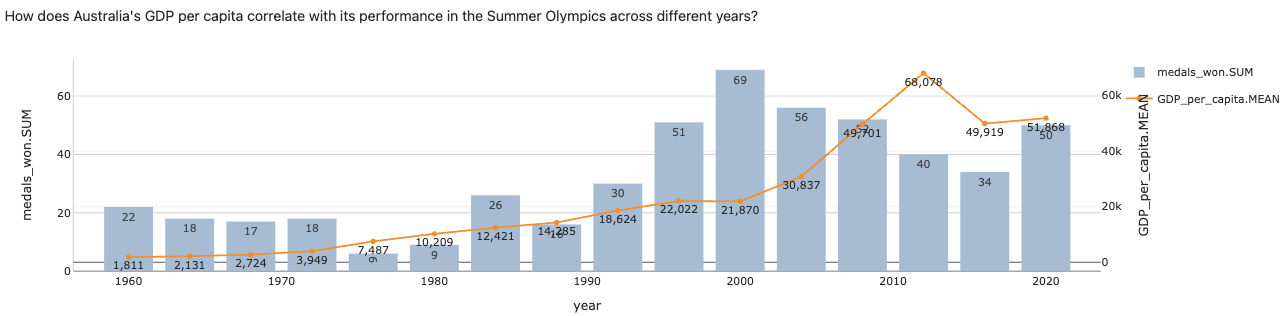

In [1635]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
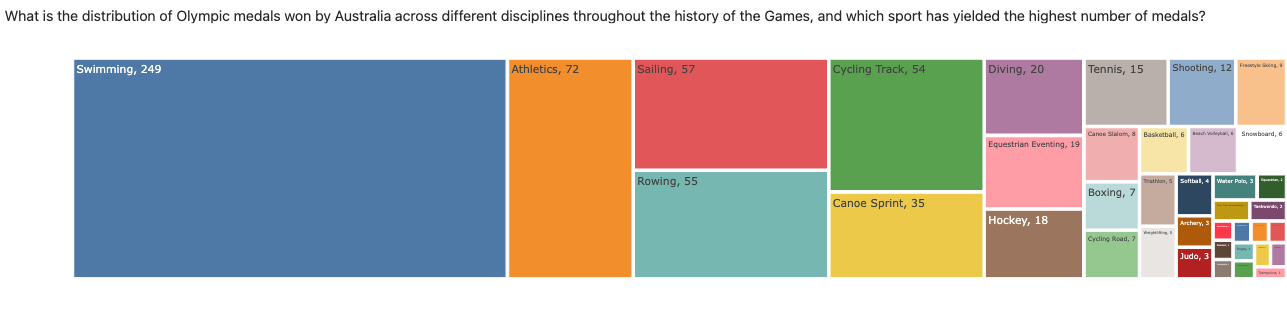

In [1634]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
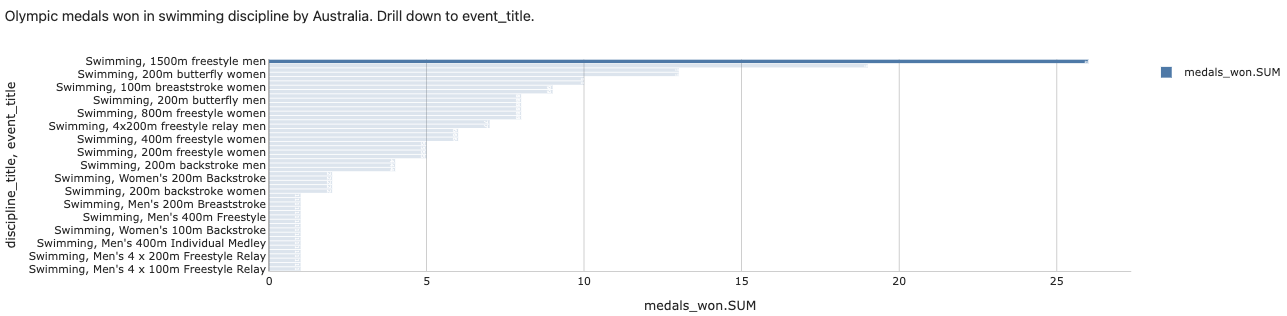

In [1636]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
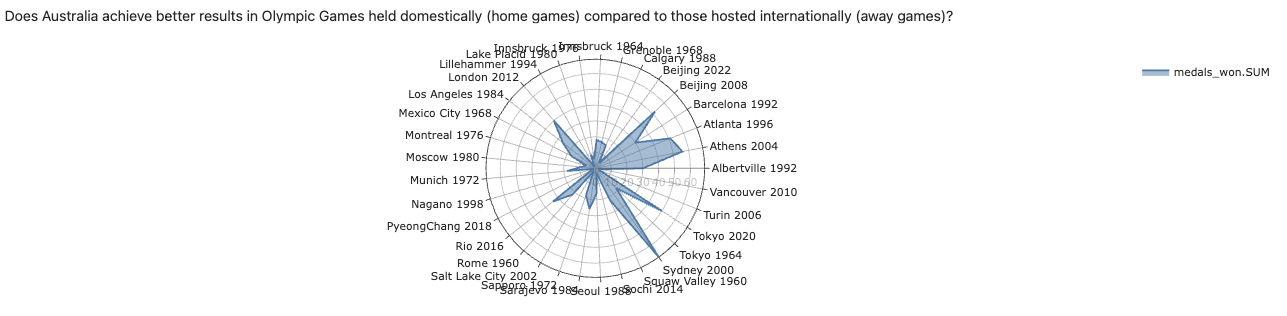

In [1637]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
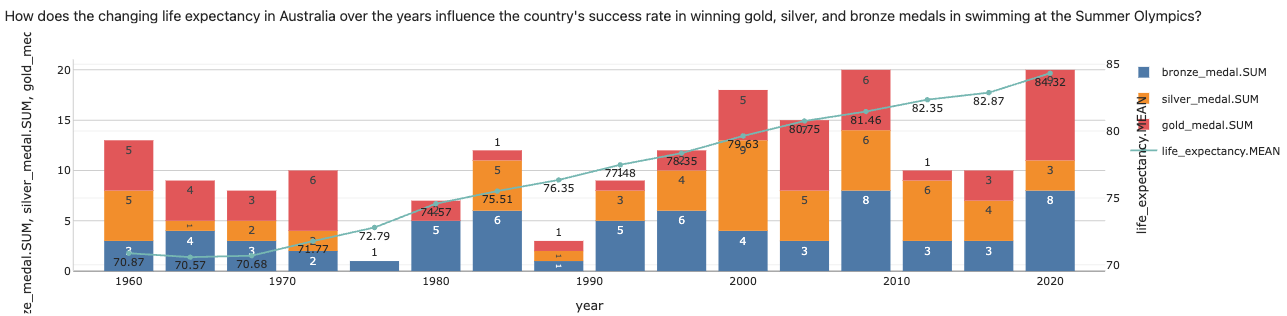

In [1638]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
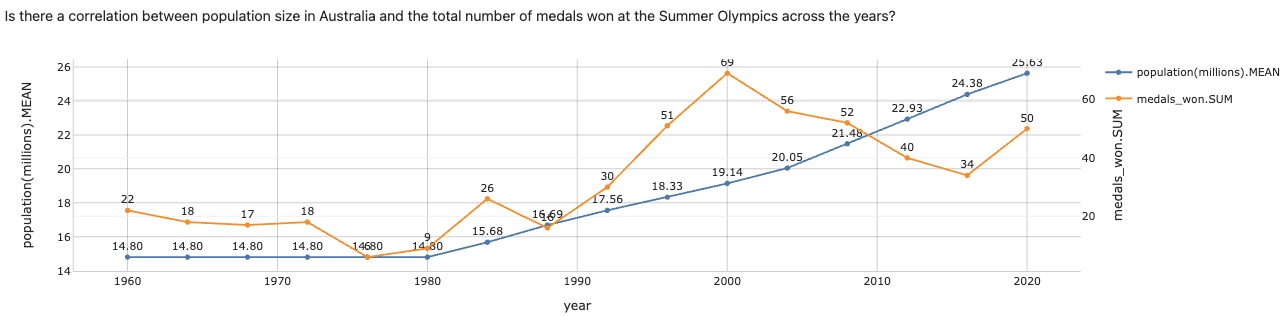

In [1639]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
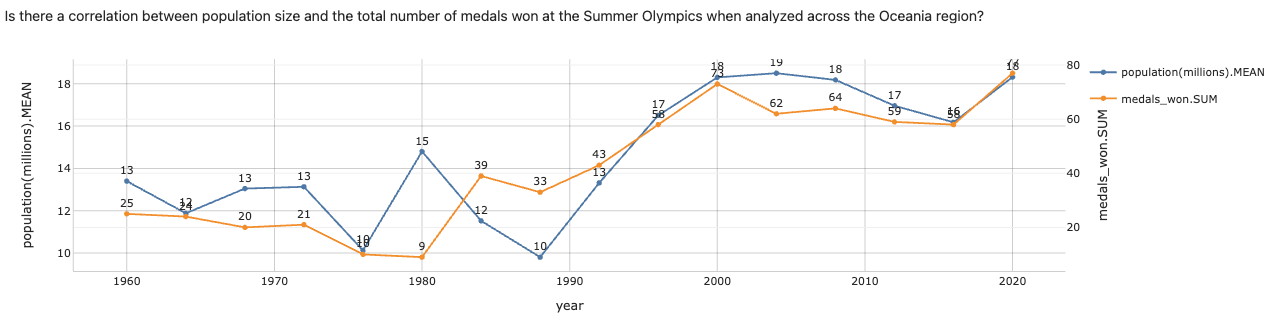

In [1640]:
session.widget

**Client B (French Government)**

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
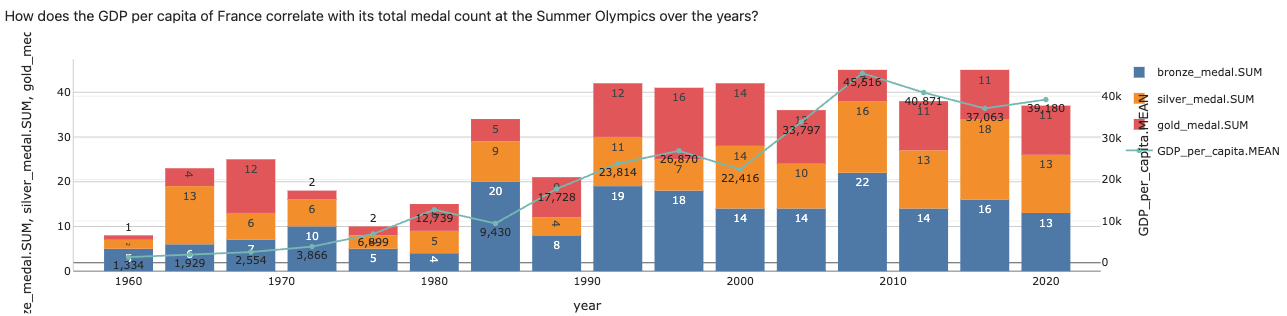

In [1641]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
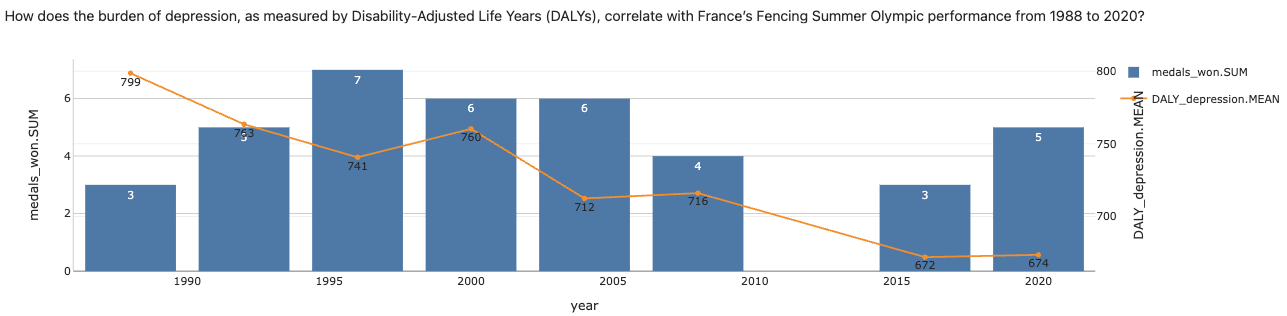

In [1642]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
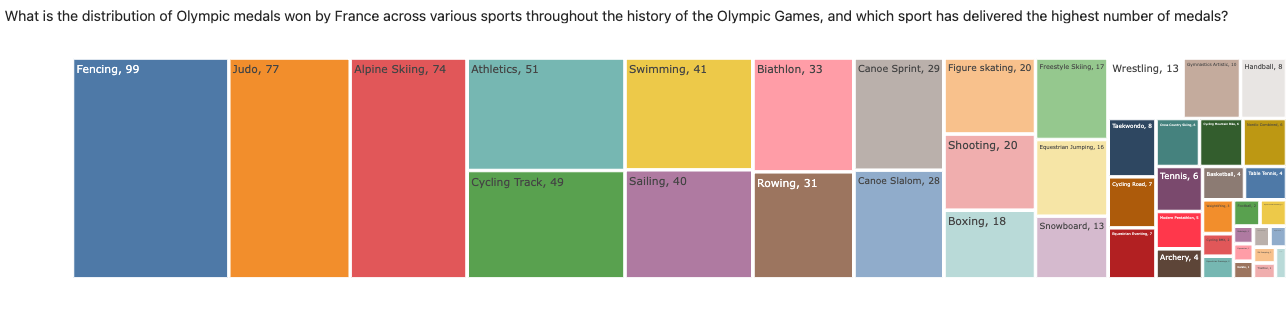

In [1643]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
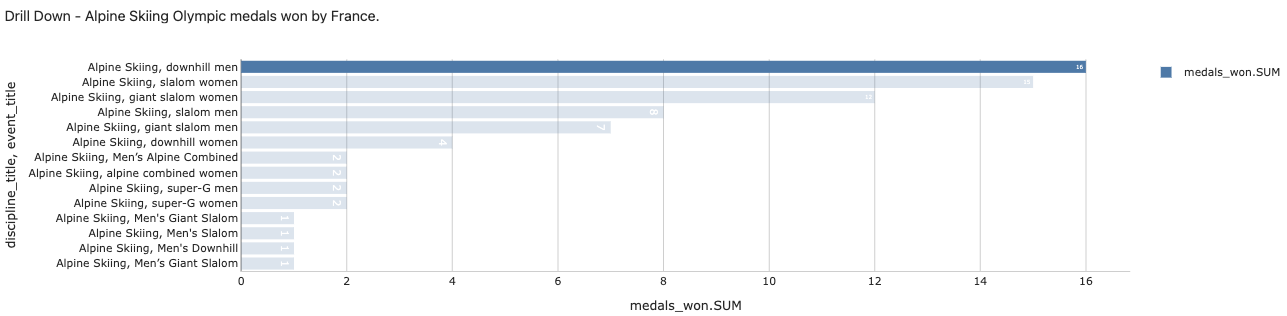

In [1644]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
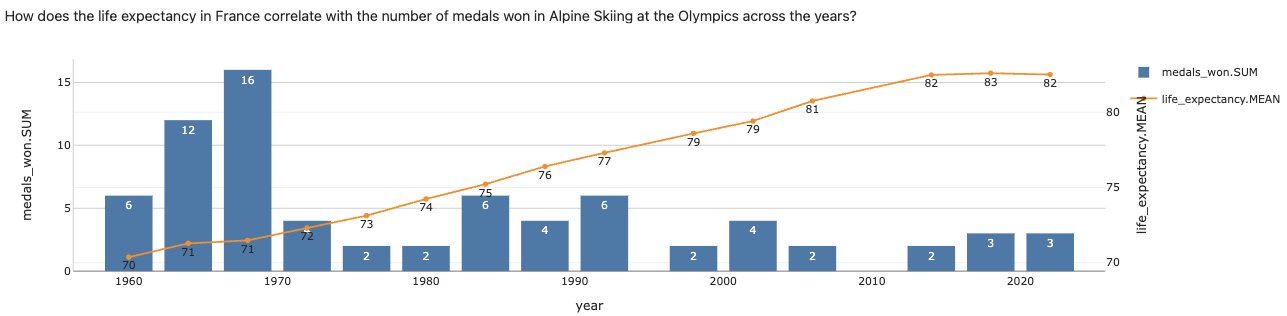

In [1645]:
session.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
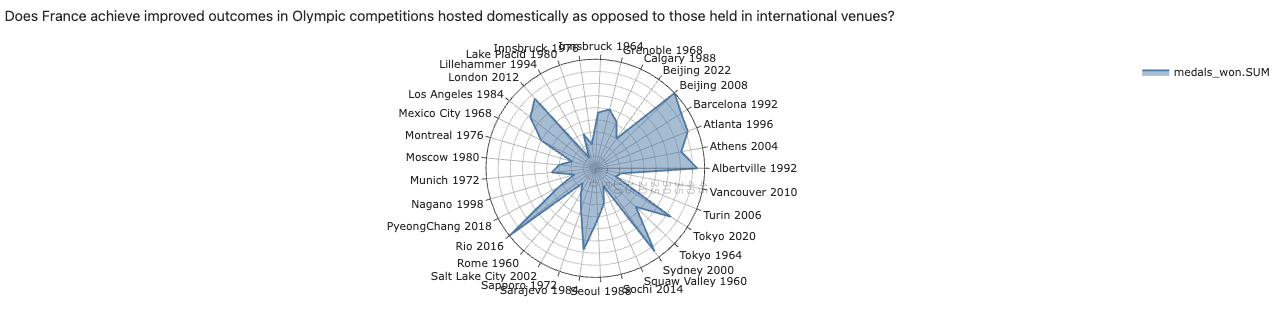

In [1646]:
session.widget

## Association rule mining

In [1192]:
#Import necessary libraries, pandas, numpy and mlxtend
import pandas as pd
import numpy as np
import mlxtend
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [1193]:
# Extract PostgreSQL tables into pandas DataFrames
fact_olympic = pd.read_sql("SELECT * FROM fact_olympic", engine)
fact_olympic.head()

,country_key,game_key,discipline_key,year_key,medals_won,gold_medal,silver_medal,bronze_medal,GDP_per_capita,government_health_expenditure_per_capita,population(millions),life_expectancy,DALY_depression,fact_id
0,1,1,1,1,1,1,0,0,34776.423234,2325.702510,59.030,82.8502,620.37820,1
1,1,1,1,1,1,1,0,0,34776.423234,2325.702510,59.030,82.8502,620.37820,2
2,2,1,1,1,1,0,1,0,108729.186903,7717.884841,5.475,83.2339,552.05084,3
3,2,1,1,1,1,0,1,0,108729.186903,7717.884841,5.475,83.2339,552.05084,4
4,3,1,1,1,1,0,0,1,56424.284699,5178.579892,10.522,82.9833,728.24680,5


**Data Preprocessing**

In [1194]:
# Grouping data by 'country_key' and 'year_key' and aggregating the medals
aggregated_data = fact_olympic.groupby(['country_key', 'year_key']).agg({
    'gold_medal': 'sum',  # Summing up all gold medals
    'silver_medal': 'sum',  # Summing up all silver medals
    'bronze_medal': 'sum',  # Summing up all bronze medals
    'medals_won':'sum',
    'GDP_per_capita': 'mean',  # Assuming GDP per capita does not change, we can take the mean 
    'government_health_expenditure_per_capita': 'mean',  # Mean health expenditure
    'population(millions)': 'mean',  # Mean population, assuming it does not vary
    'life_expectancy': 'mean',  # Mean life expectancy
    'DALY_depression': 'mean'  # Mean DALY depression
}).reset_index()


# Printing the head of the aggregated DataFrame to check
aggregated_data.head()


,country_key,year_key,gold_medal,silver_medal,bronze_medal,medals_won,GDP_per_capita,government_health_expenditure_per_capita,population(millions),life_expectancy,DALY_depression
0,1,1,3,8,8,19,34776.423234,2325.702510,59.030,82.8502,620.37820
1,1,10,8,10,11,29,35051.521270,2341.788544,60.105,82.2588,601.64404
2,1,11,0,2,6,8,35565.721377,2379.110386,60.346,82.9080,607.88617
3,1,12,28,22,28,78,804.492623,1107.179419,56.388,69.2074,652.26294
4,1,13,1,1,3,5,36035.644995,2524.387753,59.690,82.1371,597.95166


In [1195]:
# Removing unnecessary columns
aggregated_data = aggregated_data.drop(columns=['year_key', 'country_key',
                                                 'government_health_expenditure_per_capita', 'population(millions)', 'life_expectancy', 
                                                 'DALY_depression',
                                            'gold_medal', 'silver_medal', 'bronze_medal'])

# Ensure 'gdp_per_capita' is numeric and handle NaNs
aggregated_data['GDP_per_capita'] = pd.to_numeric(aggregated_data['GDP_per_capita'], errors='coerce')

# Discretize 'gdp_per_capita' into quartiles
gdp_categories = ['Very Low GDP', 'Low GDP', 'Medium GDP', 'High GDP']
aggregated_data['GDP_per_capita'] = pd.qcut(aggregated_data['GDP_per_capita'], 4, labels=gdp_categories, duplicates='drop')

# Convert 'medals_won' into categorical data
medals_categories = ['No Medals', 'Few Medals', 'Many Medals']
aggregated_data['medals_won'] = pd.cut(aggregated_data['medals_won'], [-1, 0, 8, np.inf], labels=medals_categories)

# Handle NaN values in 'gdp_per_capita' after discretization
aggregated_data['GDP_per_capita'] = aggregated_data['GDP_per_capita'].cat.add_categories('Unknown GDP').fillna('Unknown GDP')

aggregated_data

,medals_won,GDP_per_capita
0,Many Medals,High GDP
1,Many Medals,High GDP
2,Few Medals,High GDP
3,Many Medals,Very Low GDP
4,Few Medals,High GDP
...,...,...
1134,Few Medals,High GDP
1135,Few Medals,High GDP
1136,Few Medals,Medium GDP
1137,Few Medals,High GDP


**Association Rule Mining**

In [1196]:
# Convert DataFrame into a list of lists
selected_columns = ['GDP_per_capita','medals_won']
transactions = []
for index, row in aggregated_data[selected_columns].iterrows():
    transactions.append([str(row[col]) for col in selected_columns])


# Apply Transaction Encoder
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_for_mining = pd.DataFrame(te_ary, columns=te.columns_)

# Find frequent itemsets with Apriori
frequent_itemsets = apriori(df_for_mining, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Sort rules by confidence and lift
rules_sorted = rules.sort_values(['confidence', 'lift'], ascending=[False, False])

# Display top 10 rules
rules_sorted.head(10)


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
7,(Very Low GDP),(Few Medals),0.250219,0.576822,0.185250,0.740351,1.283500,0.040918,1.629808,0.294594
3,(Low GDP),(Few Medals),0.250219,0.576822,0.153644,0.614035,1.064514,0.009311,1.096416,0.080830
8,(High GDP),(Many Medals),0.250219,0.423178,0.151010,0.603509,1.426134,0.045122,1.454816,0.398521
4,(Medium GDP),(Few Medals),0.249342,0.576822,0.138718,0.556338,0.964489,-0.005107,0.953830,-0.046755
12,(Medium GDP),(Many Medals),0.249342,0.423178,0.110623,0.443662,1.048405,0.005107,1.036819,0.061506
0,(High GDP),(Few Medals),0.250219,0.576822,0.099210,0.396491,0.687372,-0.045122,0.701196,-0.377567
11,(Low GDP),(Many Medals),0.250219,0.423178,0.096576,0.385965,0.912062,-0.009311,0.939395,-0.113941
9,(Many Medals),(High GDP),0.423178,0.250219,0.151010,0.356846,1.426134,0.045122,1.165788,0.518017
6,(Few Medals),(Very Low GDP),0.576822,0.250219,0.185250,0.321157,1.283500,0.040918,1.104497,0.521956
2,(Few Medals),(Low GDP),0.576822,0.250219,0.153644,0.266362,1.064514,0.009311,1.022004,0.143213


1. Very Low GDP and Few Medals

- Rule: Countries with a Very Low GDP tend to win Few Medals.
- Metrics: High confidence (74.04%) and a lift above 1 (1.2835) indicate a strong and positive association.
- Insight: This suggests that economic challenges may limit these countries' ability to achieve higher medal counts.

2. High GDP and Many Medals

- Rule: High GDP countries tend to win Many Medals.
- Metrics: Confidence of 60.35% and a high lift of 1.4261 suggest a strong relationship where higher economic status correlates with better Olympic performance.
- Insight: Economically stronger countries likely have better sports infrastructure and resources, enhancing their athletes' performance.

3. Medium GDP and Medals

- Rules: Medium GDP is associated both with Few and Many Medals but with varying strengths.
- Metrics: For Few Medals, confidence is 55.63% with a lift below 1 (0.9645), suggesting a weak or non-positive association. For Many Medals, the lift is slightly above 1 (1.0484) with a confidence of 44.36%.
- Insight: Medium GDP countries show a mixed performance, possibly due to varying levels of investment in sports and differences in sports culture.

4. High GDP and Few Medals

- Rule: Surprisingly, there is also an association between High GDP and Few Medals.
- Metrics: Low confidence (39.65%) and a lift below 1 (0.6874) indicate that while there are instances of high GDP countries winning few medals, this is less likely than expected by chance.
- Insight: This might reflect disparities within high GDP countries, possibly due to prioritization of sports where they are less competitive.

5. Inverse Relationships (GDP to Medals and Medals to GDP)

- Rule: High GDP associated with Many Medals, and Many Medals associated back with High GDP.
- Metrics: Similar lift values (1.4261) in both directions, suggesting a strong, mutual relationship.
- Insight: This confirms that economic power and Olympic success influence each other.

6. Leverage and Zhang's Metric

- Usage: These metrics reinforce the findings from lift and confidence, where positive values suggest beneficial associations and negative values indicate either no relationship or potentially inverse relationships.

**Strategic Implications:**
- Investment in Sports: Countries, especially those with lower GDP, should consider investing in sports infrastructure and athlete training to potentially improve their Olympic medal counts.

- Policy Development: High GDP countries that underperform relative to their economic status might need to analyze their sports policies and investment distribution to identify gaps and areas for improvement.

- Diverse Sports Programs: Medium GDP countries showing variability in performance could benefit from developing programs that foster a broader range of sports, supporting both highly competitive and less represented sports.

- Data-Driven Approaches: Using these insights, national Olympic committees and sports organizations can tailor their strategies based on economic and performance data to maximize their chances of success.

These rules provide a rich dataset for national sports organizations to understand and potentially predict Olympic success, informing strategies that align economic resources with sports development goals.








### **Implementing Association Rule Mining from Scratch** 

without using the specialized mlxtend package requires a few manual steps, specifically for calculating support, confidence, and potentially lift. Implement this using just pandas and numpy:

Step 1: Preparing Data
Use aggregated_data, categorized GDP and medal counts, and handled missing data. We'll use this DataFrame to find association rules.

Step 2: Create Transaction-like Data
Transactions are typically expected to be in a list of lists, where each inner list is a transaction. Here, each country and year pair is a transaction, and items in transactions are the discretized GDP and medal categories.

Step 3: Compute Support Values
Support is computed as the fraction of transactions that contain a given itemset.

Step 4: Find Frequent Itemsets
Iteratively generate itemsets starting with 1-itemsets, 2-itemsets, etc., filtered by a minimum support threshold.

Step 5: Generate Association Rules
For those frequent itemsets, generate association rules and then calculate the confidence and lift for these rules.

In [1206]:
import pandas as pd
import numpy as np
from itertools import combinations, chain

# Convert DataFrame into a list of lists, treating each row as a transaction
transactions = aggregated_data[['GDP_per_capita', 'medals_won']].apply(lambda row: [str(item) for item in row], axis=1).tolist()

# Compute Support for all items and item combinations
def get_support(itemset, transactions):
    return sum([set(itemset).issubset(transaction) for transaction in transactions]) / len(transactions)

# Find all Frequent Itemsets
def apriori(transactions, min_support):
    # Single item support
    items = set(chain.from_iterable(transactions))
    itemsets = [{item} for item in items]
    support_dict = {frozenset(itemset): get_support(itemset, transactions) for itemset in itemsets if get_support(itemset, transactions) >= min_support}
    
    current_itemsets = [itemset for itemset, sup in support_dict.items() if sup >= min_support]
    k = 2
    while current_itemsets:
        # Generate new candidates from last frequent itemsets
        new_candidates = [frozenset(x.union(y)) for x in current_itemsets for y in current_itemsets if len(x.union(y)) == k]
        new_candidates = list(set(new_candidates))  # Remove duplicates
        # Filter new candidates by support
        valid_candidates = {frozenset(itemset): get_support(itemset, transactions) for itemset in new_candidates if get_support(itemset, transactions) >= min_support}
        support_dict.update(valid_candidates)
        current_itemsets = [itemset for itemset, sup in valid_candidates.items() if sup >= min_support]
        k += 1
    return support_dict

# Generate frequent itemsets
frequent_itemsets_support = apriori(transactions, min_support=0.01)

# Generate Association Rules from Frequent Itemsets
def generate_rules(frequent_itemsets_support, confidence_threshold):
    rules = []
    for itemset in frequent_itemsets_support.keys():
        if len(itemset) > 1:
            for consequence in combinations(itemset, 1):
                antecedent = itemset.difference(consequence)
                antecedent_support = frequent_itemsets_support[frozenset(antecedent)]
                consequence_support = frequent_itemsets_support[frozenset(consequence)]
                rule_support = frequent_itemsets_support[itemset]
                confidence = rule_support / antecedent_support
                lift = confidence / consequence_support
                if confidence >= confidence_threshold:
                    rules.append((antecedent, consequence, rule_support, confidence, lift))
    return rules

# Using a threshold for demonstration
rules = generate_rules(frequent_itemsets_support, confidence_threshold=0.1)

# Sort rules by confidence and lift
sorted_rules = sorted(rules, key=lambda x: (x[3], x[4]), reverse=True)
sorted_rules[:10]  # Display top 10 rules


[(frozenset({'Very Low GDP'}),
  ('Few Medals',),
  0.18525021949078138,
  0.7403508771929824,
  1.2835002269753533),
 (frozenset({'Low GDP'}),
  ('Few Medals',),
  0.15364354697102722,
  0.6140350877192983,
  1.0645144062591794),
 (frozenset({'High GDP'}),
  ('Many Medals',),
  0.15100965759438104,
  0.6035087719298246,
  1.4261337992283614),
 (frozenset({'Medium GDP'}),
  ('Few Medals',),
  0.13871817383669885,
  0.5563380281690141,
  0.9644886059124919),
 (frozenset({'Medium GDP'}),
  ('Many Medals',),
  0.1106233538191396,
  0.44366197183098594,
  1.0484045350943838),
 (frozenset({'High GDP'}),
  ('Few Medals',),
  0.09920983318700614,
  0.39649122807017545,
  0.6873721594702129),
 (frozenset({'Low GDP'}),
  ('Many Medals',),
  0.09657594381035997,
  0.3859649122807018,
  0.9120623134599987),
 (frozenset({'Many Medals'}),
  ('High GDP',),
  0.15100965759438104,
  0.35684647302904565,
  1.4261337992283616),
 (frozenset({'Few Medals'}),
  ('Very Low GDP',),
  0.18525021949078138,
  0

**Association Rules Explanation**

1. Very Low GDP Leads to Few Medals

Support: 18.53%
Confidence: 74.04%
Lift: 1.284
Interpretation: There's a strong and positive relationship indicating that countries with a very low GDP are likely to win few medals.

2. Low GDP Leads to Few Medals

Support: 15.36%
Confidence: 61.40%
Lift: 1.065
Interpretation: Countries with low GDP also tend to win few medals, although the relationship is weaker than with very low GDP.

3. High GDP Leads to Many Medals

Support: 15.10%
Confidence: 60.35%
Lift: 1.426
Interpretation: A strong and positive association suggests that countries with high GDP tend to win many medals.

4. Medium GDP Leads to Few Medals

Support: 13.87%
Confidence: 55.63%
Lift: 0.964
Interpretation: This inverse relationship implies that countries with medium GDP do not necessarily translate their economic status into a high number of medals.

5. Medium GDP Leads to Many Medals

Support: 11.06%
Confidence: 44.36%
Lift: 1.048
Interpretation: Medium GDP has a marginal positive relationship with winning many medals, though not as strong as high GDP.

6. High GDP Leads to Few Medals

Support: 9.92%
Confidence: 39.65%
Lift: 0.687
Interpretation: Surprisingly, there is a negative relationship where countries with high GDP may also win fewer medals than expected, indicating other factors at play.

7. Low GDP Leads to Many Medals

Support: 9.66%
Confidence: 38.60%
Lift: 0.912
Interpretation: A weaker, nearly neutral association suggests that low GDP does not strongly inhibit countries from winning many medals.

8. Many Medals Leads to High GDP

Support: 15.10%
Confidence: 35.68%
Lift: 1.426
Interpretation: This rule supports the idea that winning many medals can be an indicator of high GDP, reflecting mutual reinforcement between economic strength and Olympic success.

9. Few Medals Leads to Very Low GDP

Support: 18.53%
Confidence: 32.12%
Lift: 1.284
Interpretation: Indicates a moderate positive association, suggesting that winning few medals is common among countries with very low GDP.

10. Few Medals Leads to Low GDP

Support: 15.36%
Confidence: 26.64%
Lift: 1.065
Interpretation: This relationship is similar to the inverse of rule 2, further emphasizing the economic challenges associated with winning few medals.

**Strategic Insights:**
- These rules highlight the significant impact of economic conditions on Olympic success.
- Policies aiming to improve Olympic performance should consider economic factors, possibly addressing them through targeted sports funding and development programs.
- The inverse relationship in some high GDP scenarios suggests exploring other contributive factors like athlete training, selection processes, and sports popularity.

## What If Analysis

### Sensitivity Analysis

**Government Health Expenditure Impact:** We assume that better-funded health systems contribute to better athlete performance, so we could analyze how changes in government health expenditure impact the mean number of medals won.

In [1199]:
# Extract PostgreSQL tables into pandas DataFrames
fact_olympic = pd.read_sql("SELECT * FROM fact_olympic", engine)

In [1200]:
# Assuming that higher government health expenditure positively affects athletes' performance
# Create a sensitivity range for health expenditure increases
health_exp_increases = [1.05, 1.10, 1.15]  # 5%, 10%, 15% increases

# Iterate over increases and estimate impact on medals won
for increase in health_exp_increases:
    # Replace 'government_health_expenditure_column' with the actual column name
    fact_olympic['adjusted_health_expenditure_per_capita'] = fact_olympic['government_health_expenditure_per_capita'] * increase
    
    # Replace 'medals_won_count_column' with the actual column name for medal count
    fact_olympic['predicted_medals_won'] = fact_olympic['medals_won'] * (1 + (increase - 1))
    
    # Summarize the impact
    total_predicted_medals = fact_olympic['predicted_medals_won'].sum()
    print(f"Total predicted medals with a {increase - 1:.0%} increase in health expenditure: {total_predicted_medals}")


Total predicted medals with a 5% increase in health expenditure: 21540.750000000007
Total predicted medals with a 10% increase in health expenditure: 22566.499999999996
Total predicted medals with a 15% increase in health expenditure: 23592.25


### Scenario Analysis

**Economic Impact Scenario:** Analyze how fluctuations in GDP per capita, which reflects the country's economic situation, might affect Olympic performance.

In [1201]:
# Define scenarios: Economic Boom and Economic Downturn
gdp_growth_rates = {'Economic Boom': 1.10, 'Economic Downturn': 0.90}

# Apply scenarios to GDP per capita and estimate impact on medals won
for scenario, growth_rate in gdp_growth_rates.items():
    fact_olympic['adjusted_gdp_per_capita'] = fact_olympic['GDP_per_capita'] * growth_rate
    # Assuming that a higher GDP per capita means better funding for athletes
    # A simple model might just scale medals won by the GDP growth rate
    fact_olympic['predicted_medals_won'] = fact_olympic['medals_won'] * growth_rate
    total_predicted_medals = fact_olympic['predicted_medals_won'].sum()
    print(f"Total predicted medals in {scenario}: {total_predicted_medals}")


Total predicted medals in Economic Boom: 22566.499999999996
Total predicted medals in Economic Downturn: 18463.500000000004


**Interpretation of Results from the What-If Analysis:**

**1. Health Expenditure Increase:**
- **With a 5% increase in health expenditure**, the total predicted medals won is 21,540.75. This substantial increase suggests that even a slight boost in health funding could significantly enhance Olympic performance, presumably due to improved healthcare and support systems for athletes.

- **With a 10% increase**, the total predicted medals won rises to 22,566.5, indicating a continued improvement in performance with higher investment in health. This trend reaffirms the potential benefits of investing in athlete health and wellness.

- **With a 15% increase**, the predicted total reaches 23,592.25. The consistent increase in predicted medals with higher health expenditure underscores a potential direct correlation between health investment and Olympic success.

**2. GDP Scenarios:**
- Under the **'Economic Boom' scenario**, which assumes a 10% increase in GDP per capita, the total predicted medals won matches the outcome of a 10% increase in health expenditure, at 22,566.5. This alignment suggests that economic prosperity, reflected by GDP growth, significantly contributes to Olympic success, likely through enhanced funding and resources for sports programs.

- Conversely, in the **'Economic Downturn' scenario**, assuming a 10% decrease in GDP per capita, the total predicted medals won drops to 18,463.5. This decline indicates that economic hardships can detrimentally impact Olympic performance, likely due to cutbacks in sports funding and suboptimal conditions for athlete training.

**Interpreting the Findings for the Client:**
- Investment in Athlete Health: Increased health expenditure is predicted to lead to better athlete performance. This could be due to enhanced healthcare facilities, improved injury management, and overall superior athlete welfare, which are crucial for top-tier performance.

- Economic Impact: The prosperity of a country, as measured by GDP per capita, appears closely linked to its Olympic success. Strategic investments in both the economy and sports infrastructure during times of economic growth could yield better results. Conversely, during economic downturns, maintaining investment in sports could help mitigate potential declines in performance.

**Strategy Suggestions:**
- Invest in Health Programs and Facilities: Encourage incremental increases in health expenditure for athletes, as this has been shown to potentially yield substantial improvements in Olympic results.

- Establish Economic Safety Nets: Develop financial safety nets or reserve funds to support athletes and sports programs during economic downturns, helping to stabilize performance levels despite fiscal challenges.

- Foster Public and Private Partnerships: Promote partnerships between government bodies and private sectors to diversify funding sources. This can reduce dependency on fluctuating government budgets and provide a more stable financial environment for athletes.

Each interpretation assumes a direct causal relationship between the adjusted variables (health expenditure and GDP per capita) and Olympic success. It's critical to clarify to the client that while the analysis suggests correlations, causation cannot be definitively established without further detailed study. Additional research and possibly controlled experiments would be necessary to verify these causal links.